In [1]:
import os
import warnings

import math
import pycbc
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from matplotlib.ticker import ScalarFormatter

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

warnings.filterwarnings('ignore')

/home/ashishthomas.mathew/.conda/envs/gengli_env/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
from modules import statistical_testing

We load the CSV that contains all glitch times from the first half of the third observing run.

In [3]:
glitches = pd.read_csv('./glitches/O3a_allifo.csv', usecols=['GPStime', 'snr', 'duration', 'confidence', 'ifo', 'label'])
glitches = glitches[~glitches.duplicated(subset=['GPStime'], keep='first')]
glitches.columns

Index(['GPStime', 'snr', 'duration', 'confidence', 'ifo', 'label'], dtype='object')

In [4]:
# example = pd.read_csv("./gspy_glitches/gspy_tomtes.csv", usecols=['event_time', 'ifo', 'duration', 'snr', 'confidence', 'ml_label'])

As you can see it contains a bunch of columns. 
- **GPStime**: The timestamp in GPS format indicating the event time.
- **peakFreq**: The frequency at which the signal has the highest intensity.
- **snr**: Signal-to-noise ratio, indicating the clarity of the signal.
- **amplitude**: The strength or height of the signal wave.
- **centralFreq**: The central frequency of the signal's spectral content.
- **duration**: The time span of the signal event.
- **bandwidth**: The range of frequencies covered by the signal.
- **chisq**: The chi-squared statistic for assessing signal fit quality.
- **chisqDof**: The degrees of freedom used in the chi-squared test.
- **confidence**: The likelihood or certainty of the detection.
- **id**: A unique identifier for the signal event.
- **ifo**: The interferometer associated with the signal detection.
- **label**: Classification or annotation of the event.
- **imgUrl**: Link to an image or visual representation of the signal.
- **Q-value**: Quality factor indicating the sharpness of the signal.

I will be removing the columns that are not relevant to us.

Let's take a look at the **label** column to see all the different glitch classes.

In [5]:
glitches.columns

Index(['GPStime', 'snr', 'duration', 'confidence', 'ifo', 'label'], dtype='object')

In [6]:
glitches['label'].unique()

array(['Extremely_Loud', 'Scattered_Light', 'Scratchy',
       'Power_Line', 'Koi_Fish', 'Whistle',
       'Low_Frequency_Burst', 'Tomte', 'Repeating_Blips',
       'Fast_Scattering', 'Blip', 'Blip_Low_Frequency',
       'Violin_Mode', 'Helix', 'None_of_the_Above',
       'Low_Frequency_Lines', 'Wandering_Line', 'No_Glitch',
       'Air_Compressor', 'Chirp', 'Light_Modulation',
       'Paired_Doves', '1400Ripples', '1080Lines'], dtype=object)

In [7]:
selected = glitches[(glitches['label'] == 'Tomte') & (glitches['ifo'] == 'L1')]
len(selected), len(selected)

(18708, 18708)

In [8]:
np.round(np.mean(selected['duration'].values), 2)

np.float64(0.66)

You can see that 'Tomte' of 'L1' is a subset of the initial data set. How long are they?

In [9]:
np.unique(selected['duration'])

array([ 0.039,  0.047,  0.055, ..., 13.169, 19.25 , 24.813])

In [10]:
selected.loc[selected["GPStime"] == 1248343512.793]

GPStime      snr  duration  confidence ifo  label
1041 1248343512.79300 22.43900   0.87500     1.00000  L1  Tomte

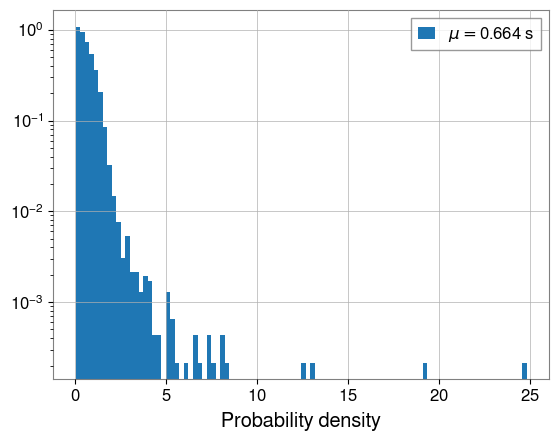

In [11]:
plt.hist(selected['duration'].values, bins=100, density=True,
         label=f'$\mu=$'+str(np.round(np.mean(selected['duration'].values), 3))+' s')
plt.yscale('log')
plt.xlabel('Duration (s)')
plt.xlabel('Probability density')
plt.legend()

On average they are 0.664 s long, so we can visualize then in 2s. Let's pick a random example and visualize it.

The `statistical_testing` module contains a function `fetch_glitch_data()` that fetches info from the LIGO OSC for L1 at a given gps time for 3 seconds at a sample rate of 4096. This sample is then converted to the pycbc format and whitened.

```python
noise = TimeSeries.fetch_open_data(ifo, g_star - tw ,  g_star + tw, sample_rate=srate)
```

In [12]:
selected[selected['duration']>=10]

GPStime      snr  duration  confidence ifo  label
38273  1239976866.13700 13.24300  19.25000     1.00000  L1  Tomte
74992  1240305857.61300 25.06600  12.56300     1.00000  L1  Tomte
102336 1238912479.12900 10.23800  13.16900     0.99800  L1  Tomte
174353 1249731970.62900 61.24300  24.81300     0.95400  L1  Tomte

In [13]:
data_df_tomte = statistical_testing.fetch_glitch_data_from_csv(selected, begin=0, n_samples=250)

OK, now we can check its Gaussianity with Saphiro test. We test that the input time series (y) is Gaussian, against the alternative hypothesis that it is non-Gaussian. If the test yields a p-value below $\alpha=0.05$ it means that the input data is non-Gaussian

Using the code above, we load up the dataset

Changing the sampling rate increases the amount of times we sample from the data per second. I want to know how the p-values would vary with this change. The gwpy [documentation](https://gwpy.github.io/docs/latest/api/gwpy.timeseries.TimeSeries/#gwpy.timeseries.TimeSeries.fetch_open_data) states that there can be event data with a 16384 Hz sampling rate which is what I will be using as a reference.

In [14]:
data_df_tomte.head()

GPStime      snr  duration  confidence ifo  label  \
0 1243679045.58200 35.21000   1.25000     1.00000  L1  Tomte   
1 1250540898.89500 32.25600   1.50000     1.00000  L1  Tomte   
2 1249463266.05900 32.08200   1.50000     1.00000  L1  Tomte   
3 1243933155.99600 29.36500   1.16000     1.00000  L1  Tomte   
4 1246398633.91000 28.77600   0.87500     1.00000  L1  Tomte   

                                   glitch_timeseries  \
0  [-1.0854155103346084e-19, -1.3654645578018337e...   
1  [1.7812745717014414e-19, 1.7493877360218948e-1...   
2  [3.910350888002077e-21, 1.8948101948847326e-21...   
3  [6.128452972915836e-19, 6.161272497036812e-19,...   
4  [5.663362620411331e-20, 5.866555943670273e-20,...   

                                                   y  \
0  [8.733267214504934, 35.936071332558065, 0.0269...   
1  [-27.600632021544072, -37.95740276396919, -14....   
2  [22.950040635453366, 21.570729941449233, -80.1...   
3  [9.143258910472538, 10.416690111540754, 46.022...   
4  [-125.10521957316229, 112.67416405406193, -65....   

                                                   t  \
0  [1.5 s, 1.500244140625 s, 1.50048828125 s, 1.5...   
1  [1.5 s, 1.500244140625 s, 1.50048828125 s, 1.5...   
2  [1.5 s, 1.500244140625 s, 1.50048828125 s, 1.5...   
3  [1.5 s, 1.500244140625 s, 1.50048828125 s, 1.5...   
4  [1.5 s, 1.500244140625 s, 1.50048828125 s, 1.5...   

                                              q_scan  shapiro_statistic  \
0  [[FrequencySeries(2.1660795\n                u...            0.98595   
1  [[FrequencySeries(1.8224314\n                u...            0.98875   
2  [[FrequencySeries(1.8986453\n                u...            0.98722   
3  [[FrequencySeries(0.08010445\n                ...            0.98530   
4  [[FrequencySeries(0.621742\n                un...            0.98673   

   shapiro_pvalue  shapiro_prediction  ks_statistic  ks_pvalue  ks_prediction  \
0         0.00000                   1       0.37207    0.00000              1   
1         0.00000                   1       0.28882    0.00000              1   
2         0.00000                   1       0.43140    0.00000              1   
3         0.00000                   1       0.20312    0.00000              1   
4         0.00000                   1       0.48267    0.00000              1   

   ad_statistic                   ad_critical_values  \
0       3.15951  [0.575, 0.655, 0.786, 0.917, 1.091]   
1       2.36182  [0.575, 0.655, 0.786, 0.917, 1.091]   
2       3.11714  [0.575, 0.655, 0.786, 0.917, 1.091]   
3       3.47017  [0.575, 0.655, 0.786, 0.917, 1.091]   
4       2.45871  [0.575, 0.655, 0.786, 0.917, 1.091]   

         ad_significance_level  kurtosis     skew  
0  [15.0, 10.0, 5.0, 2.5, 1.0]   4.71692 -0.28133  
1  [15.0, 10.0, 5.0, 2.5, 1.0]   4.48187 -0.22691  
2  [15.0, 10.0, 5.0, 2.5, 1.0]   4.54284 -0.29837  
3  [15.0, 10.0, 5.0, 2.5, 1.0]   4.71418 -0.36852  
4  [15.0, 10.0, 5.0, 2.5, 1.0]   4.66576 -0.35843

In [15]:
# def p_values_with_sample_rate(begin=0,end=100):
#     data_df_4096 = get_noise_data(selected, tw=3, begin=begin, end=end)
#     data_df_16384 = get_noise_data(selected, tw=3, begin=begin, end=end)

#     data_df_4096['shapiro_pvalue'] = data_df_4096['y'].apply(lambda y: stats.shapiro(y).pvalue)
#     data_df_16384['shapiro_pvalue'] = data_df_16384['y'].apply(lambda y: stats.shapiro(y).pvalue)
    
#     display_shapiro_stats(data_df_4096, 3)
#     display_shapiro_stats(data_df_16384, 3)

#     return data_df_4096, data_df_16384


# data_df_4096, data_df_16384 = p_values_with_sample_rate()



We also check the equality of the numpy arrays to 100% confirm that the distributions are the same. Here we see that the p-values differ by a small margin (in the scale of $10^{-15}$) at to points. At first I thought this was particular to certain values, but on further experimentation, this could most probably be chalked up to floating point precision errors.

In [16]:
# plt.plot(difference)
# plt.xlabel("Index")
# plt.ylabel("Difference in p-values")
# plt.title("Difference in Shapiro p-values (4096 Hz vs. 16384 Hz)")
# plt.show()

Next would be checking the timeframe over which we conduct the test. This is more likely to change the shapiro values as we are increasing the number of points over which we are doing these calculations.

In [17]:
# def p_values_with_time_width():
#     data_df_3 = get_noise_data(selected, tw=3, begin=100, end=150)
#     data_df_4 = get_noise_data(selected, tw=4, begin=100, end=150)
#     data_df_5 = get_noise_data(selected, tw=5, begin=100, end=150)

#     data_df_3['shapiro_pvalue'] = data_df_3['y'].apply(lambda y: stats.shapiro(y).pvalue)
#     data_df_4['shapiro_pvalue'] = data_df_4['y'].apply(lambda y: stats.shapiro(y).pvalue)
#     data_df_5['shapiro_pvalue'] = data_df_5['y'].apply(lambda y: stats.shapiro(y).pvalue)
    
#     display_shapiro_stats(data_df_3, 3)
#     display_shapiro_stats(data_df_4, 4)
#     display_shapiro_stats(data_df_5, 5)

#     return data_df_3, data_df_4, data_df_5


# data_df_3, data_df_4, data_df_5 = p_values_with_time_width()

My hunch was right. The p-values have changed. This could probably be because we are considering more data points as we increase the time window.

Ignoring The outlier, we now focus on values below 0.05

In [18]:
# def view_filtered_histograms_tw(threshold = 0.065):
#     filtered_3 = data_df_3[data_df_3['shapiro_pvalue'] <= 0.06]
#     filtered_4 = data_df_4[data_df_4['shapiro_pvalue'] <= 0.06]
#     filtered_5 = data_df_5[data_df_5['shapiro_pvalue'] <= 0.06]

#     fig, ax = plt.subplots(1, 3, figsize=(21, 6))

#     ax[0].hist(filtered_3['shapiro_pvalue'])
#     ax[0].set_xlabel("Shapiro p-value")
#     ax[0].set_ylabel("Frequency")
#     ax[0].set_title("Shapiro p-values ≤ 0.01 (Time Window = 3s)")


#     ax[1].hist(filtered_4['shapiro_pvalue'])
#     ax[1].set_xlabel("Shapiro p-value")
#     ax[1].set_ylabel("Frequency")
#     ax[1].set_title("Shapiro p-values ≤ 0.01 (Time Window = 4s)")

#     ax[2].hist(filtered_5['shapiro_pvalue'])
#     ax[2].set_xlabel("Shapiro p-value")
#     ax[2].set_ylabel("Frequency")
#     ax[2].set_title("Shapiro p-values ≤ 0.01 (Time Window = 5s)")
#     plt.show()

# view_filtered_histograms_tw()

In [19]:
# fig = plt.figure(figsize=(10, 6))
# fig = plt.figure(dpi=200)

# plt.plot(data_df_3['shapiro_pvalue'], color='blue', alpha=0.3)
# plt.plot(data_df_4['shapiro_pvalue'], color='orange', alpha=0.3)
# plt.plot(data_df_5['shapiro_pvalue'], color='green', alpha=0.3)

# plt.xlabel('Glitch Instance')
# plt.ylabel('p-value')
# plt.title('Comparison of Shapiro p-values with differing time windows')
# plt.legend(['filtered_3', 'filtered_4', 'filtered_5'])
# plt.show()

What I find interesting in these graphs is that the p-values for a time window of 3s fluctuate between 0 to 0.04, for 4s, it fluctuates from 0 to 0.005, and for 5s it is between 0 to 0.05



I now want to investigate the glitch that was classified but was failing this test. I'll use `data_df_tomte` for this

In [20]:
data_df_tomte['ewm_y'] = data_df_tomte['y'].apply(lambda row: pd.Series(row).ewm(0.9).mean().tolist())
# data_df_tomte['ewm_q_transform'] = data_df_tomte['ewm_y'].apply(lambda row: TimeSeries(row, sample_rate=4096).q_transform(qrange=[4,64], frange=[10, 2048], tres=0.002, fres=0.5, whiten=False))
data_df_tomte['ewm_q_transform'] = data_df_tomte['ewm_y'].apply(lambda row: TimeSeries(row, sample_rate=4096).q_transform(qrange=[4,64], frange=[10, 2048], tres=0.002, fres=0.5, whiten=False))

In [21]:
data_df_tomte.iloc[0]

GPStime                                                   1243679045.58200
snr                                                               35.21000
duration                                                           1.25000
confidence                                                         1.00000
ifo                                                                     L1
label                                                                Tomte
glitch_timeseries        [-1.0854155103346084e-19, -1.3654645578018337e...
y                        [8.733267214504934, 35.936071332558065, 0.0269...
t                        [1.5 s, 1.500244140625 s, 1.50048828125 s, 1.5...
q_scan                   [[FrequencySeries(2.1660795\n                u...
shapiro_statistic                                                  0.98595
shapiro_pvalue                                                     0.00000
shapiro_prediction                                                       1
ks_statistic             

In [22]:
suspicious_glitch = data_df_tomte[data_df_tomte['shapiro_pvalue'] >= 0.05]
suspicious_glitch

GPStime      snr  duration  confidence ifo  label  \
201 1251419205.83200 18.00100   0.75000     1.00000  L1  Tomte   
239 1241711101.47300 16.08900   0.43900     1.00000  L1  Tomte   

                                     glitch_timeseries  \
201  [-1.3597081426545253e-20, -9.31465196867568e-2...   
239  [-2.0746733557404072e-19, -2.1288199654571774e...   

                                                     y  \
201  [29.16121667375581, 94.66529378808767, 6.32355...   
239  [16.222474333849448, 29.36424586029554, 80.278...   

                                                     t  \
201  [1.5 s, 1.500244140625 s, 1.50048828125 s, 1.5...   
239  [1.5 s, 1.500244140625 s, 1.50048828125 s, 1.5...   

                                                q_scan  shapiro_statistic  \
201  [[FrequencySeries(1.3943119\n                u...            0.99963   
239  [[FrequencySeries(0.18476272\n                ...            0.99924   

     shapiro_pvalue  shapiro_prediction  ks_statistic  ks_pvalue  \
201         0.66941                   0       0.02515    0.14997   
239         0.08002                   0       0.08325    0.00000   

     ks_prediction  ad_statistic                   ad_critical_values  \
201              0       0.44434  [0.575, 0.655, 0.786, 0.917, 1.091]   
239              1       0.44943  [0.575, 0.655, 0.786, 0.917, 1.091]   

           ad_significance_level  kurtosis     skew  \
201  [15.0, 10.0, 5.0, 2.5, 1.0]   3.01565 -0.04049   
239  [15.0, 10.0, 5.0, 2.5, 1.0]   3.12963 -0.09342   

                                                 ewm_y  \
201  [29.16121667375581, 73.61041185848099, 33.9847...   
239  [16.222474333849448, 25.14010501250929, 57.611...   

                                       ewm_q_transform  
201  [[FrequencySeries(1.6861959\n                u...  
239  [[FrequencySeries(1.4850954\n                u...

In [23]:
# fig, ax = plt.subplots(1,2, figsize=(12, 6))
# ax[0].plot(suspicious_glitch['t'].iloc[0], suspicious_glitch['y'].iloc[0], label='Suspicious Glitch')
# ax[0].set_xlabel("Time (s)")
# ax[0].set_ylabel("Amplitude")
# ax[0].legend()

# ax[1].imshow(suspicious_glitch['q_transform'].iloc[0])
# ax[1].set_yscale('log', base=2)
# ax[1].set_xscale('linear')
# ax[1].set_ylabel('Frequency (Hz)')
# ax[1].set_xlabel('Time (s)')
# ax[1].images[0].set_clim(0, 25.5)

# fig.colorbar(ax[1].images[0], ax=ax[1], label='Normalized energy', orientation='vertical', fraction=0.046, pad=0.04)

# plt.show()

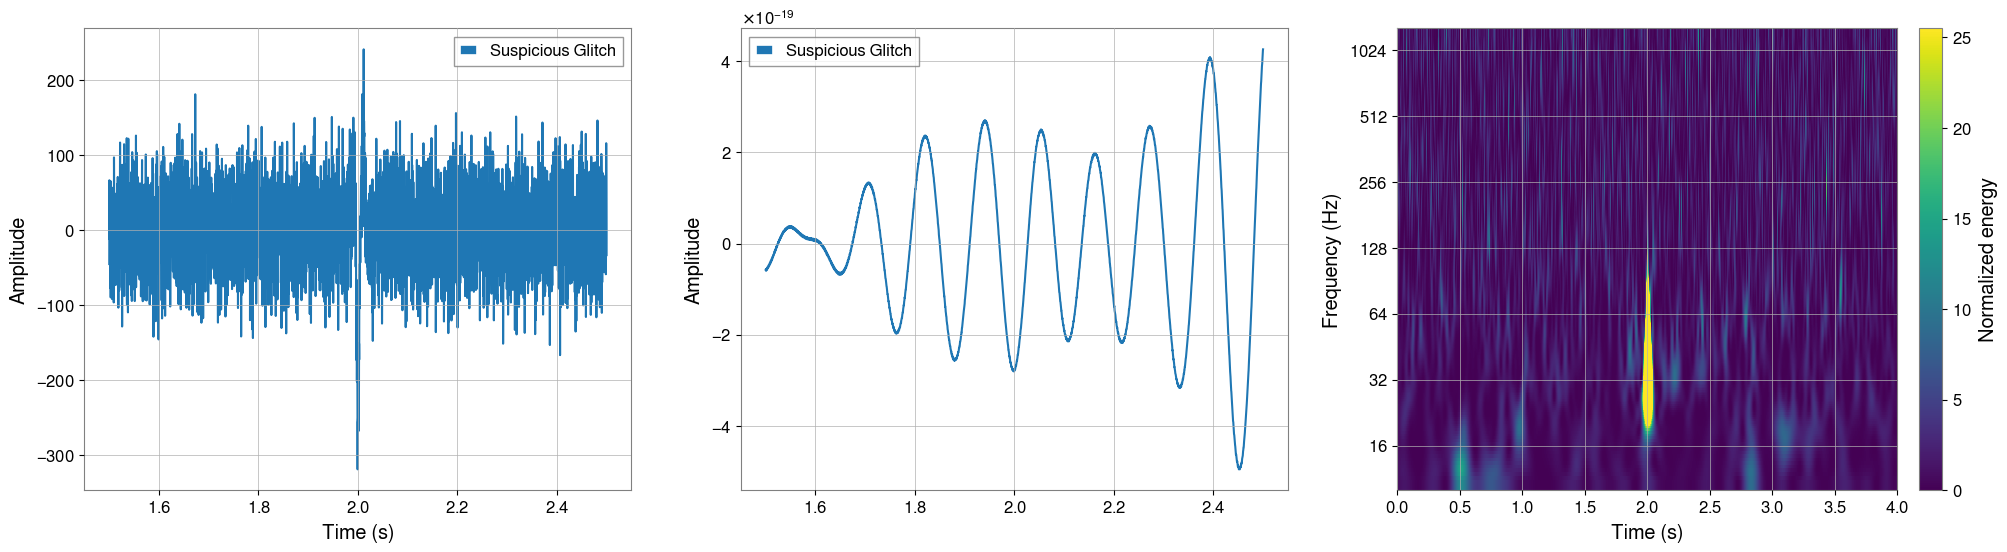

In [24]:
glitch_idx = 9

fig, ax = plt.subplots(1,3, figsize=(24, 6))
ax[0].plot(data_df_tomte['t'].iloc[glitch_idx], data_df_tomte['y'].iloc[glitch_idx], label='Suspicious Glitch')
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Amplitude")
ax[0].legend()

ax[1].plot(data_df_tomte['t'].iloc[glitch_idx],data_df_tomte["glitch_timeseries"].iloc[glitch_idx], label='Suspicious Glitch')
# ax[2].set_xlabel("Time (s)")
ax[1].set_ylabel("Amplitude")
ax[1].legend()

ax[2].imshow(data_df_tomte['q_scan'].iloc[glitch_idx])
ax[2].set_yscale('log', base=2)
ax[2].set_xscale('linear')
ax[2].set_ylabel('Frequency (Hz)')
ax[2].set_xlabel('Time (s)')
ax[2].images[0].set_clim(0, 25.5)
fig.colorbar(ax[2].images[0], ax=ax[2], label='Normalized energy', orientation='vertical', fraction=0.046, pad=0.04)

plt.show()

The glitch with a p-value above 0.05 does look gaussian in the time-amplitude domain, but its q-transform makes it look similar to the other glitches.

Now, I want to compare this glitch to the other ones to see if its distribution is similar to theirs and by how much. The Kolmogorov-Smirnov test is suitable for this as it provides a statistic and p-value to work with.

In [25]:
# sus_y_values = suspicious_glitch.iloc[0]['y']

# ks_stats = list(data_df_tomte['y'].apply(lambda row: tuple(stats.ks_2samp(row,sus_y_values))))

In [26]:
# ks_stats = pd.DataFrame(ks_stats, columns=['suspicious_KS_statistic', 'suspicious_KS_p_value'])
# data_df_tomte = data_df_tomte.join(ks_stats[['suspicious_KS_statistic', 'suspicious_KS_p_value']])

Now that I have the KS statistic and p-values, I can now see how the suspicious glitch here fares with the others

In [27]:
# fig, ax = plt.subplots(1,2, figsize=(12, 6))

# # plt.title("Kolmogorov Smirnov Statistic and P-values of data compared to outlier glitch")
# ax[0].plot(data_df_tomte['suspicious_KS_statistic'])
# ax[0].set_ylabel("KS statistic")
# ax[0].set_xlabel("Glitch Instance")

# ax[1].plot(data_df_tomte['suspicious_KS_p_value'])
# ax[1].set_ylabel('KS p-value')
# ax[1].set_xlabel('Glitch Instance')

# plt.show()

Due to how much this statistic varies with each of the glitches in our sample set, it will probably not be of much use to us in determining whether the glitch that we are studying is similar to the other ones are not. Additionally the KS test doesn't take into consideration the temporal nature of our data, which is problematic.

An idea I wanted to try for this was [Dynamic Time Warping](https://en.wikipedia.org/wiki/Dynamic_time_warping). This algorithm can compare the simlarities between two temporal sequences, taking into account their speed (warping). However this assumes there to be a phase shift between the timeseries and does not account for changes in amplitudes. 

In our case, we would go for something akin to lock-step distance. The main issue however is the whitening that has been done to our signal.

Since our signal is being introduced to white noise, it is effectively a vaguely glitch-like white noise signal that we are dealing with. I could try applying a weighted average that would help capture the general trend of the glitch as it moves along, along with either one of the two methods.

We first do the lock-step calculations with the glitches directly

In [28]:
# def lock_step(sus, row):
#     return np.sqrt(((sus-row)**2).sum())

# data_df_tomte['lock_step_distance'] = data_df_tomte['y'].apply(lambda row: lock_step(np.array(row) , np.array(sus_y_values)))

In [29]:
# fig = plt.figure(dpi=100)
# plt.plot(data_df_tomte['lock_step_distance'])

# plt.xlabel('Glitch Instance')
# plt.ylabel('Lock-step distance')
# plt.title('Lock-step distances of whitened glitches compared to the suspicious glitch')
# plt.show()

We notice that a lot of the lock-step distance values hover around the 5500 t0 6100 range. However there are some points where the variation is extremely high. I want to compare this with th KS statistic to see the parallels.

In [30]:
# fig, ax = plt.subplots(1,2, figsize=(12, 6))

# ax[0].plot(data_df_tomte['suspicious_KS_statistic'])
# ax[0].set_ylabel("KS statistic")
# ax[0].set_xlabel("Glitch Instance")

# ax[1].plot(data_df_tomte['lock_step_distance'])
# ax[1].set_ylabel('Lock-step distance')
# ax[1].set_xlabel('Glitch Instance')

# plt.show()

We notice that both these plots have spikes at similar points, having a zero value at point 28 (the suspicious glitch).

I'll now take the weighted average and do the same. First i want to see what our suspicious glitch looks when taken as a weighted average.

In [31]:
# fig, ax = plt.subplots(2,2, figsize=(13, 12))
# ax[0][0].plot(suspicious_glitch['t'].iloc[0], suspicious_glitch['y'].iloc[0], label='Suspicious Glitch')
# ax[0][0].set_xlabel("Time (s)")
# ax[0][0].set_ylabel("Amplitude")
# ax[0][0].legend()

# ax[0][1].plot(suspicious_glitch['t'].iloc[0], suspicious_glitch['ewm_y'].iloc[0], label='Suspicious Glitch (EWM)')
# ax[0][1].set_xlabel("Time (s)")
# ax[0][1].set_ylabel("Amplitude")
# ax[0][1].legend()
# # ax[1].images[0].set_clim(0, 25.5)

# ax[1][0].imshow(suspicious_glitch['q_transform'].iloc[0])
# ax[1][0].set_yscale('log', base=2)
# ax[1][0].set_xscale('linear')
# ax[1][0].set_ylabel('Frequency (Hz)')
# ax[1][0].set_xlabel('Time (s)')
# ax[1][0].images[0].set_clim(0, 25.5)
# fig.colorbar(ax[1][0].images[0], ax=ax[1][0], label='Normalized energy', orientation='vertical', fraction=0.046, pad=0.04)

# ax[1][1].imshow(suspicious_glitch['ewm_q_transform'].iloc[0])
# ax[1][1].set_yscale('log', base=2)
# ax[1][1].set_xscale('linear')
# ax[1][1].set_ylabel('Frequency (Hz)')
# ax[1][1].set_xlabel('Time (s)')
# ax[1][1].images[0].set_clim(0, 25.5)

# plt.subplots_adjust(wspace=0.4, hspace=0.4)

# fig.colorbar(ax[1][1].images[0], ax=ax[1][1], label='Normalized energy', orientation='vertical', fraction=0.046, pad=0.04)

# plt.show()

# Testing EWA on white noise

0.7408084478567447


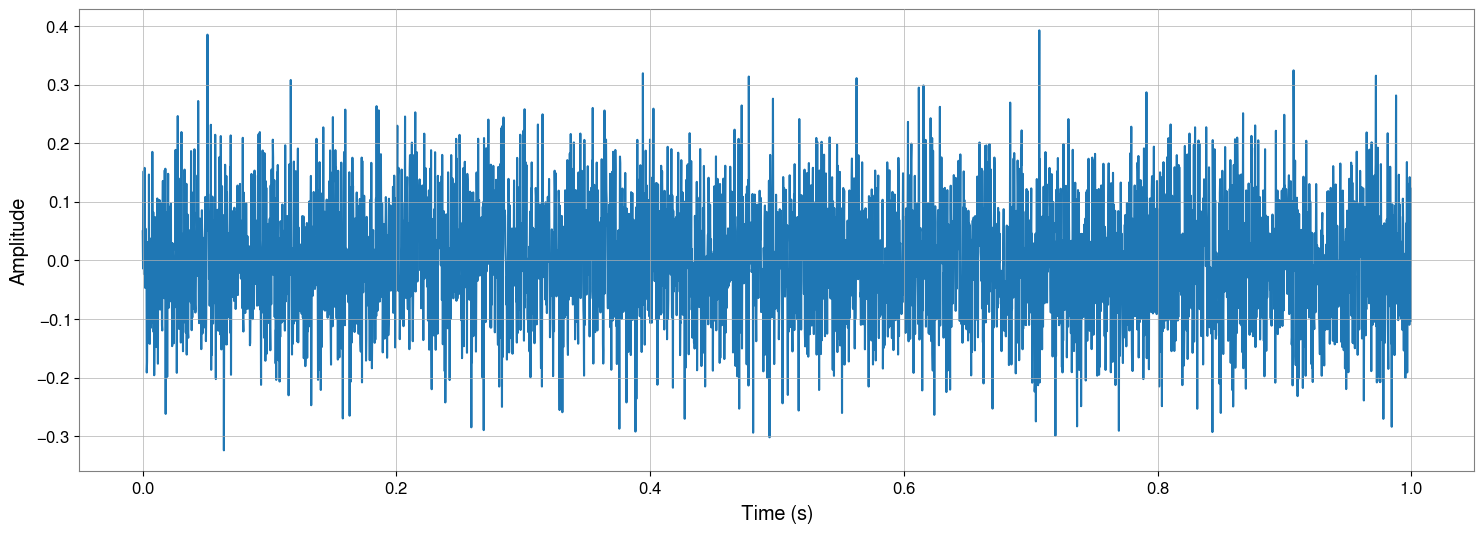

In [32]:
# creating noise
example_noise = TimeSeries(np.random.normal(scale=.1, size=4096), sample_rate=4096)
print(stats.shapiro(example_noise.value).pvalue)
fig = plt.figure(figsize=(18,6))
plt.plot(example_noise)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [33]:
ewm_example_1 = pd.Series(example_noise.value).ewm(0).mean()
ewm_example_2 = pd.Series(example_noise.value).ewm(0.5).mean()
ewm_example_3 = pd.Series(example_noise.value).ewm(0.8).mean()
ewm_example_4 = pd.Series(example_noise.value).ewm(0.9).mean()
ewm_example_5 = pd.Series(example_noise.value).ewm(0.98).mean()
ewm_example_6 = pd.Series(example_noise.value).ewm(0.9999).mean()

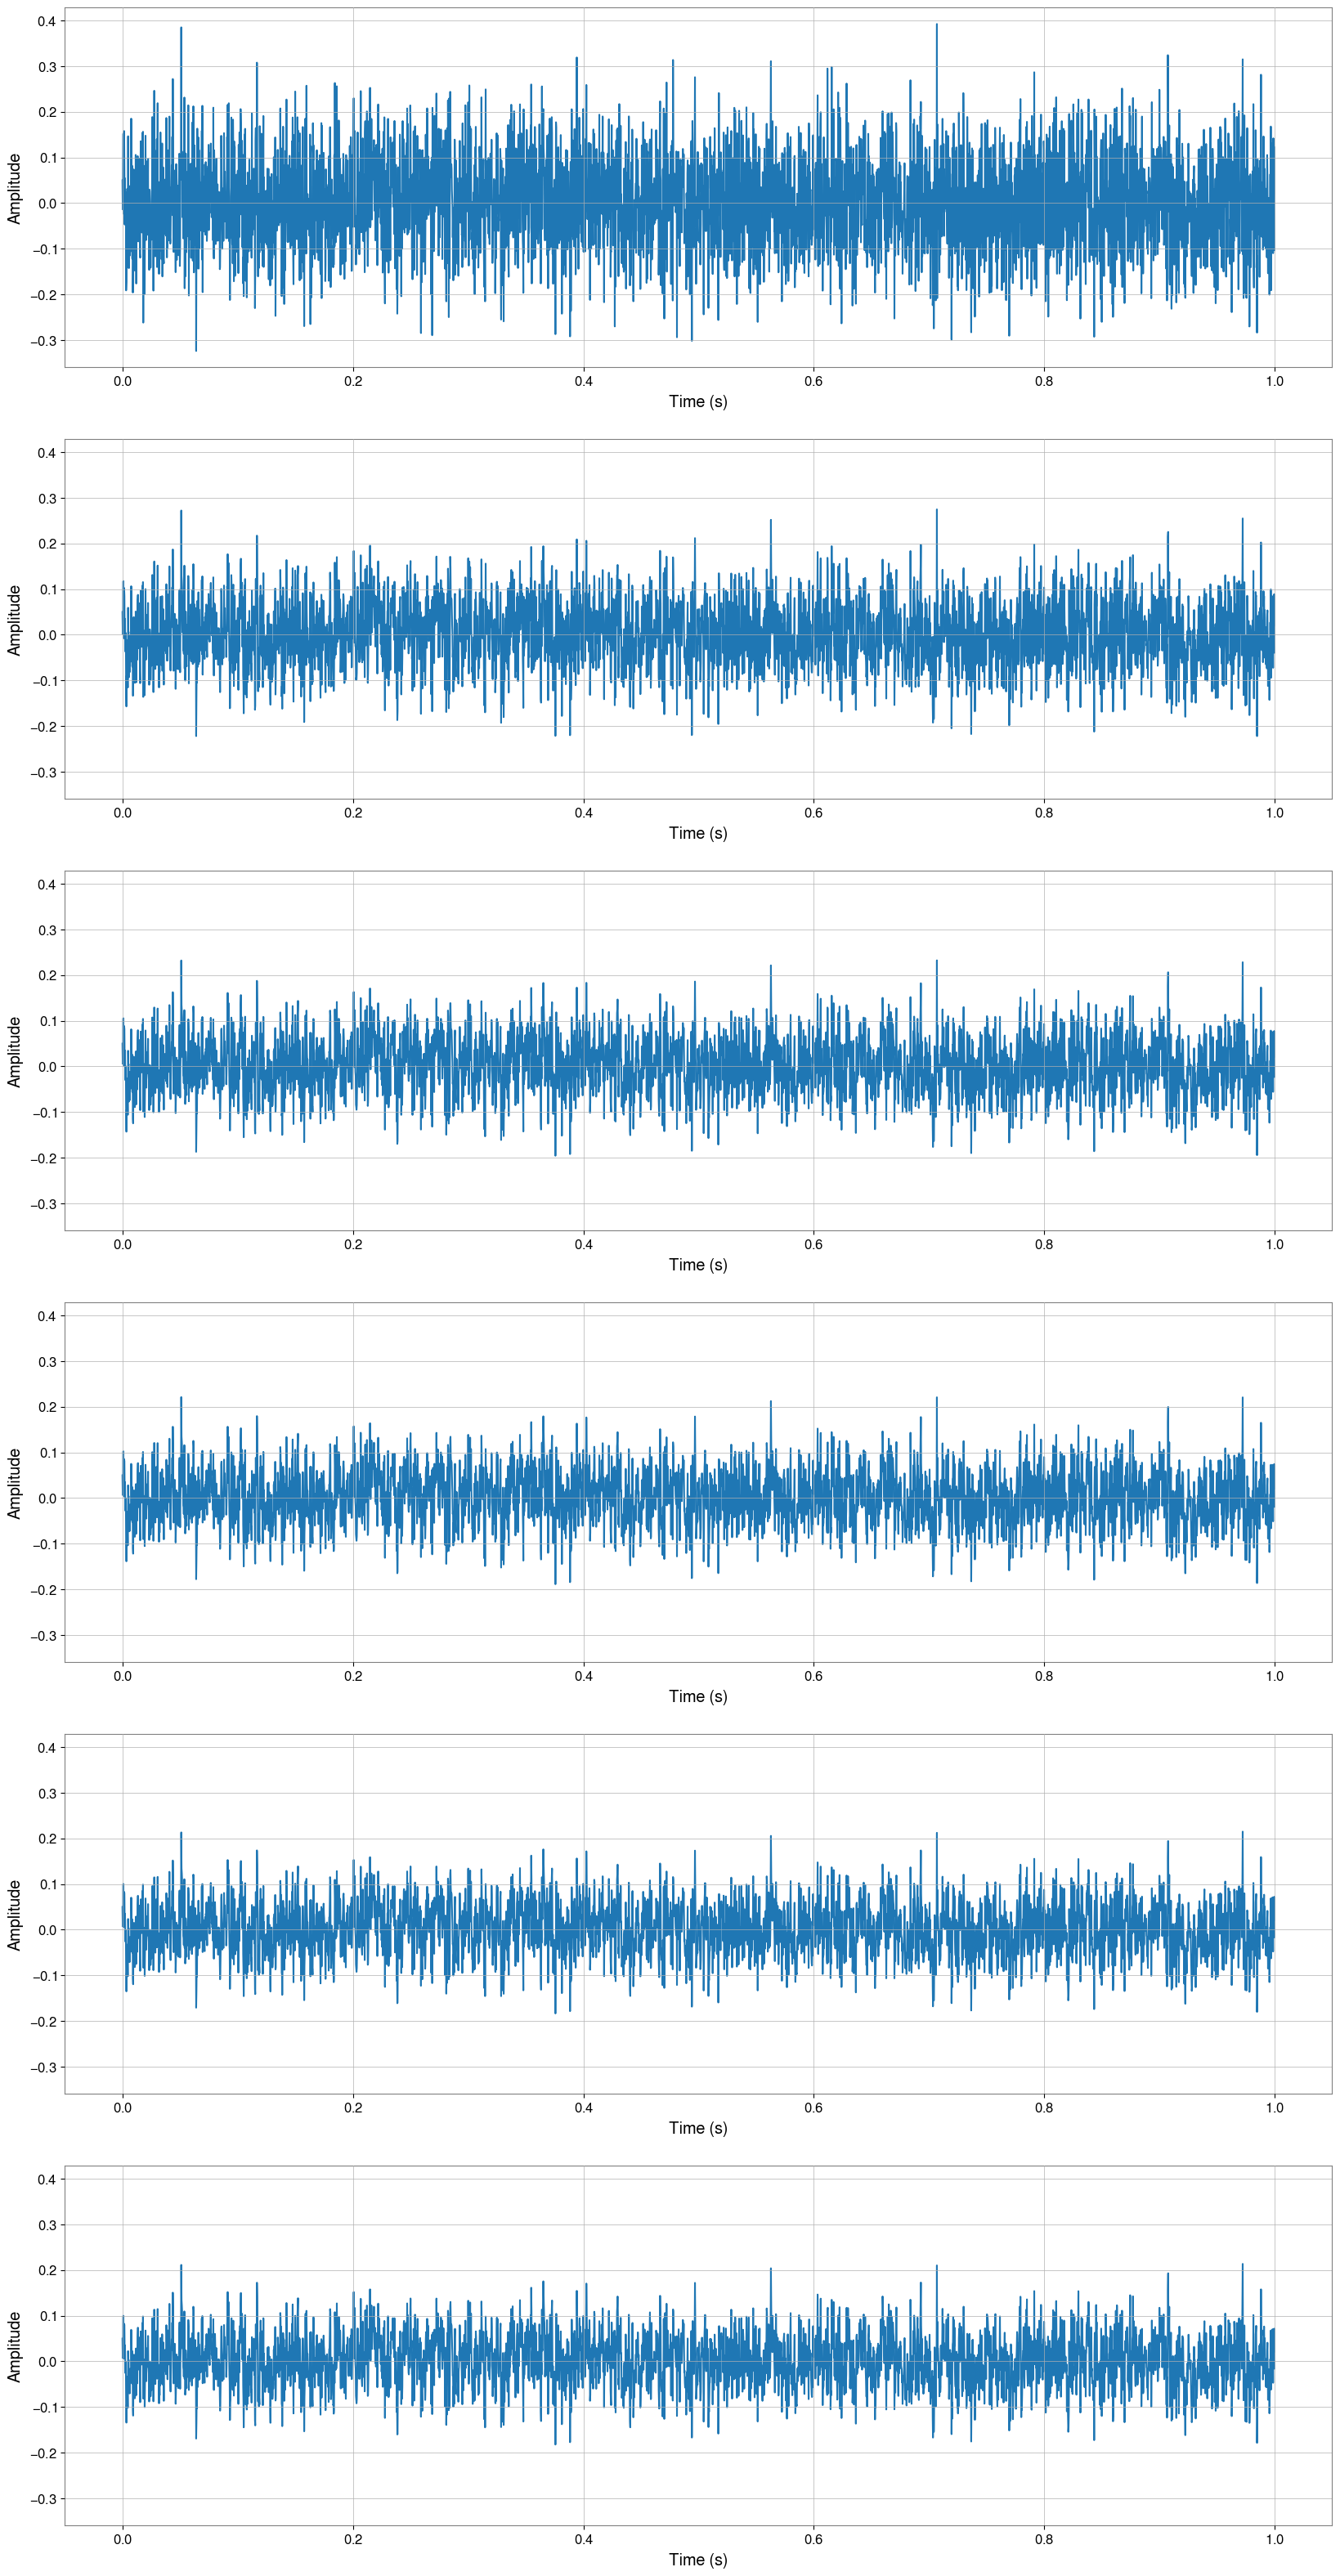

In [34]:
fig, ax = plt.subplots(6, 1, figsize=(20,40), sharey=True, dpi=100)

ax[0].plot(example_noise.times, ewm_example_1)
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Amplitude")

ax[1].plot(example_noise.times, ewm_example_2)
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Amplitude")

ax[2].plot(example_noise.times, ewm_example_3)
ax[2].set_xlabel("Time (s)")
ax[2].set_ylabel("Amplitude")

ax[3].plot(example_noise.times, ewm_example_4)
ax[3].set_xlabel("Time (s)")
ax[3].set_ylabel("Amplitude")

ax[4].plot(example_noise.times, ewm_example_5)
ax[4].set_xlabel("Time (s)")
ax[4].set_ylabel("Amplitude")

ax[5].plot(example_noise.times, ewm_example_6)
ax[5].set_xlabel("Time (s)")
ax[5].set_ylabel("Amplitude")

plt.show()

What's happening here is that the effective values following the first sample are dampened with the following formula

$$\text{ewm}_{t} = \alpha \text{ val}_{t} + (1 - \alpha) \text{ewm}_{t-1}$$

where $\text{ewm}_{t}$ is the exponentially weighted mean at $t$, and $\alpha$ is a user defined value between $(0,1)$

So at every point, we take into account previous points in our timeseries. Hence, the white noise is not necessarily going to remain as white noise.

Also, from a visual standpoint, the glitch seems to be converging to the mean, which in this case is zero since the white noise here is zero centered.

# Using the Shapiro Wilks test on smaller parts of a glitch

We now take our suspicious glitch and perform the Shapiro-Wilks test on sections of it.

Shapiro Statistics
0.3217586290892464
0.5922384197378889
0.9165606216106661
0.12461696482890056
0.7352125502468464
0.7066965822516067
0.03597689480008047
0.09858480497250423
0.23825290029050494
0.8513121046708538
0.981168311969316
0.7811106304033817
0.40590391039256984
0.417804509722116
0.04408005172370262
0.1510712973959426


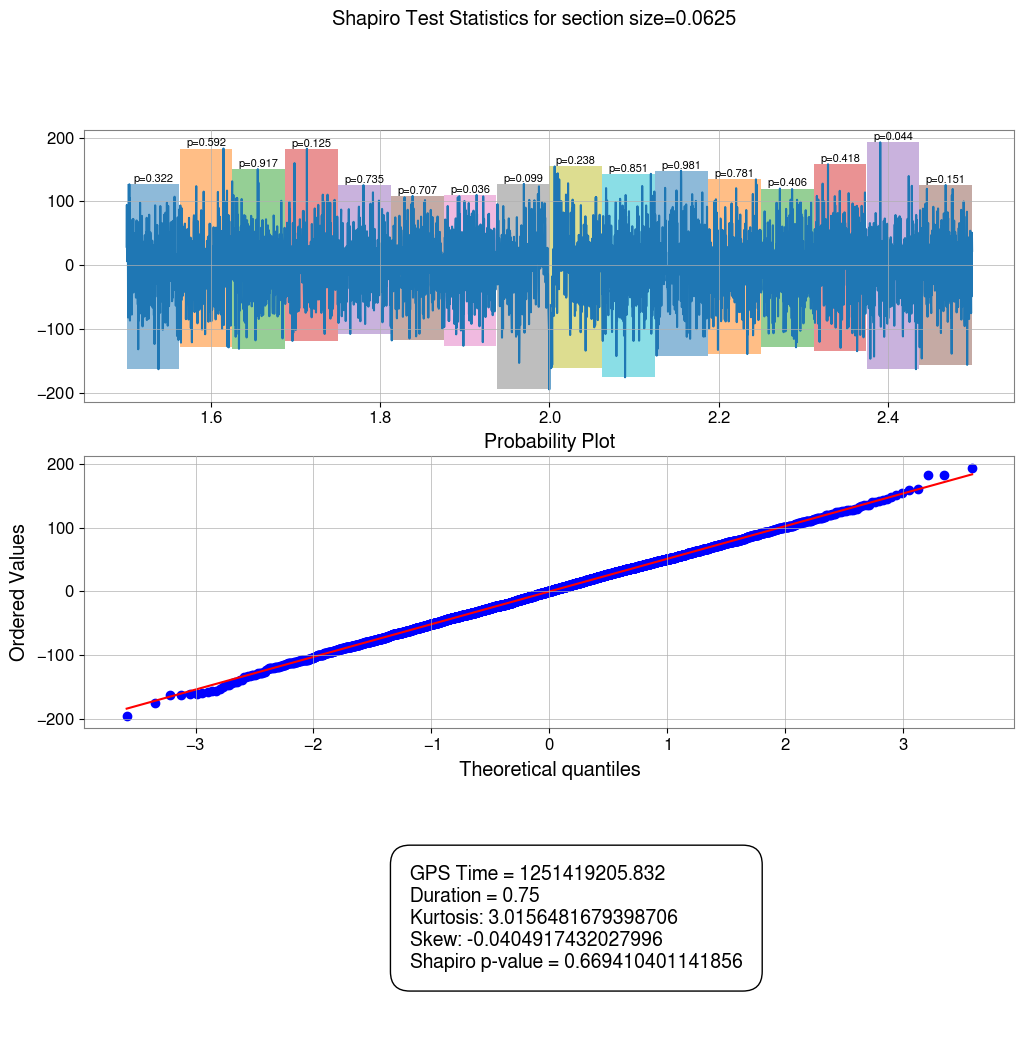

In [35]:
# statistical_testing.display_section_statistics(suspicious_glitch.iloc[0],stat_test="Shapiro", sections=16) # 256
statistical_testing.display_section_statistics(suspicious_glitch.iloc[0],stat_test="Shapiro", section_size_seconds=0.0625) # 256 (16)


Shapiro Statistics
0.49113775569963647
0.31049822995514165
0.5284955978576942
0.36757223801247846


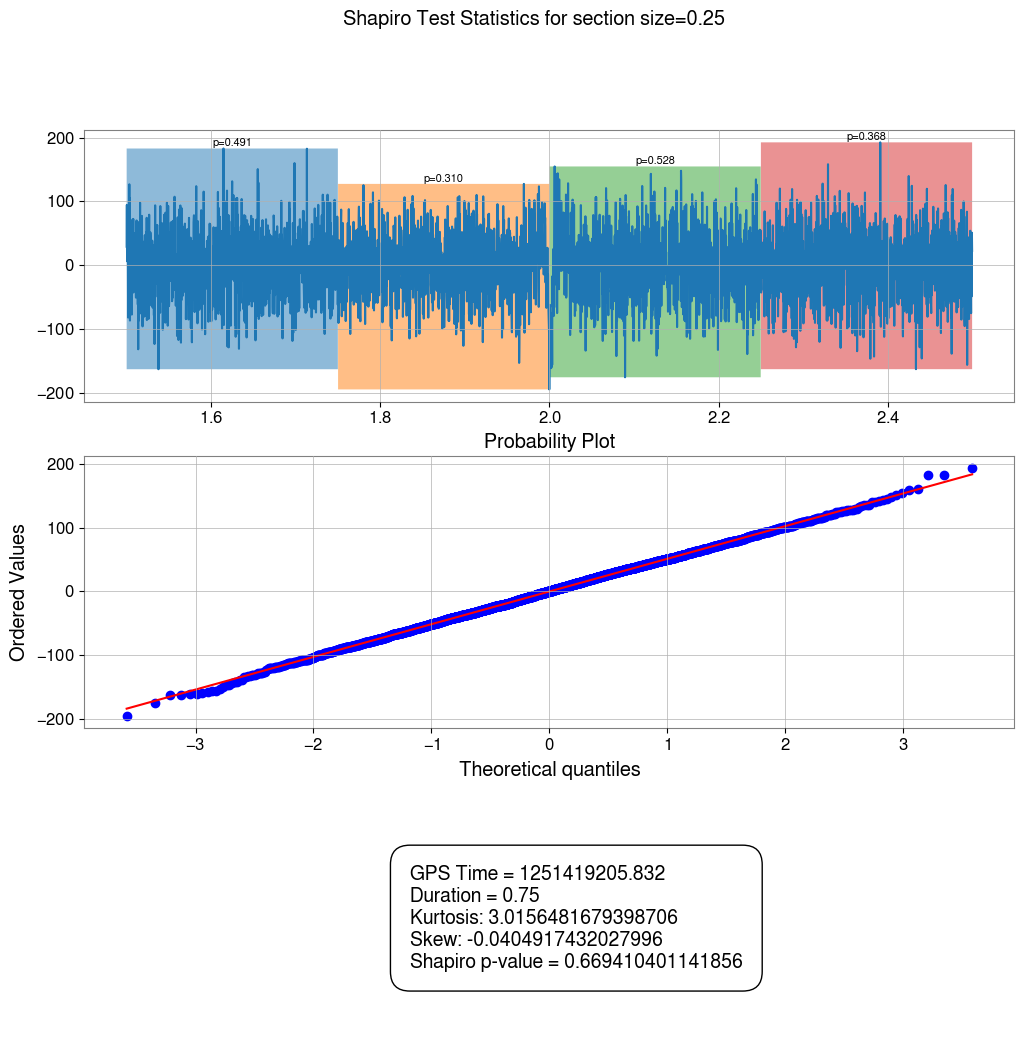

In [36]:
# statistical_testing.display_section_statistics(suspicious_glitch.iloc[0],stat_test="Shapiro", sections=4)
statistical_testing.display_section_statistics(suspicious_glitch.iloc[0],stat_test="Shapiro", section_size_seconds=0.25) # 1024 (4)

Shapiro Statistics
0.4609298221321781
0.3669623515479599
0.45264928877386673


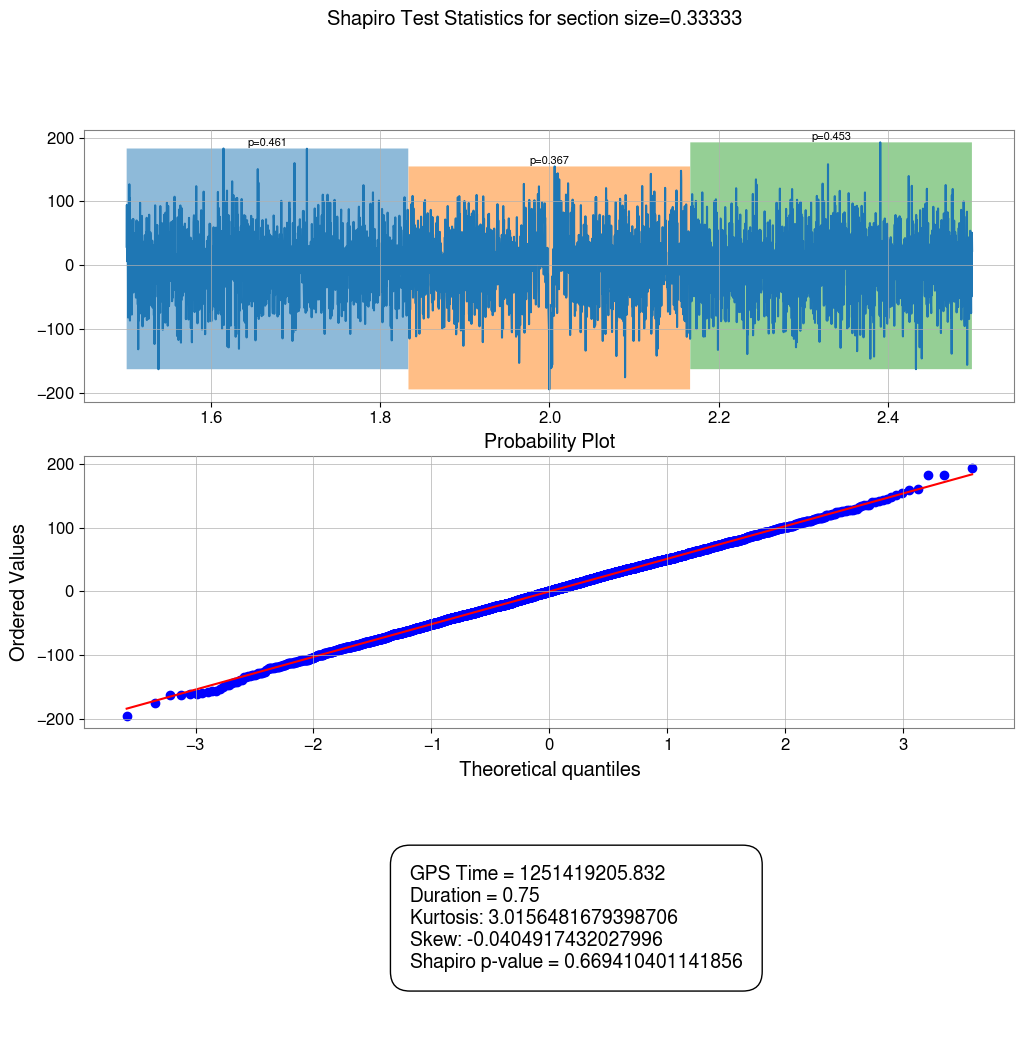

In [37]:
# statistical_testing.display_section_statistics(suspicious_glitch.iloc[0],stat_test="Shapiro", sections=3)
statistical_testing.display_section_statistics(suspicious_glitch.iloc[0],stat_test="Shapiro", section_size_seconds=0.33333) #1365 (3)

Shapiro Statistics
0.4619830487691886
0.0425211879237208
0.48769524578409207
0.04073614918876886
0.07959663840726561
0.9339071471610286
0.699264587442596
0.4438228319096536
0.20259342207065884


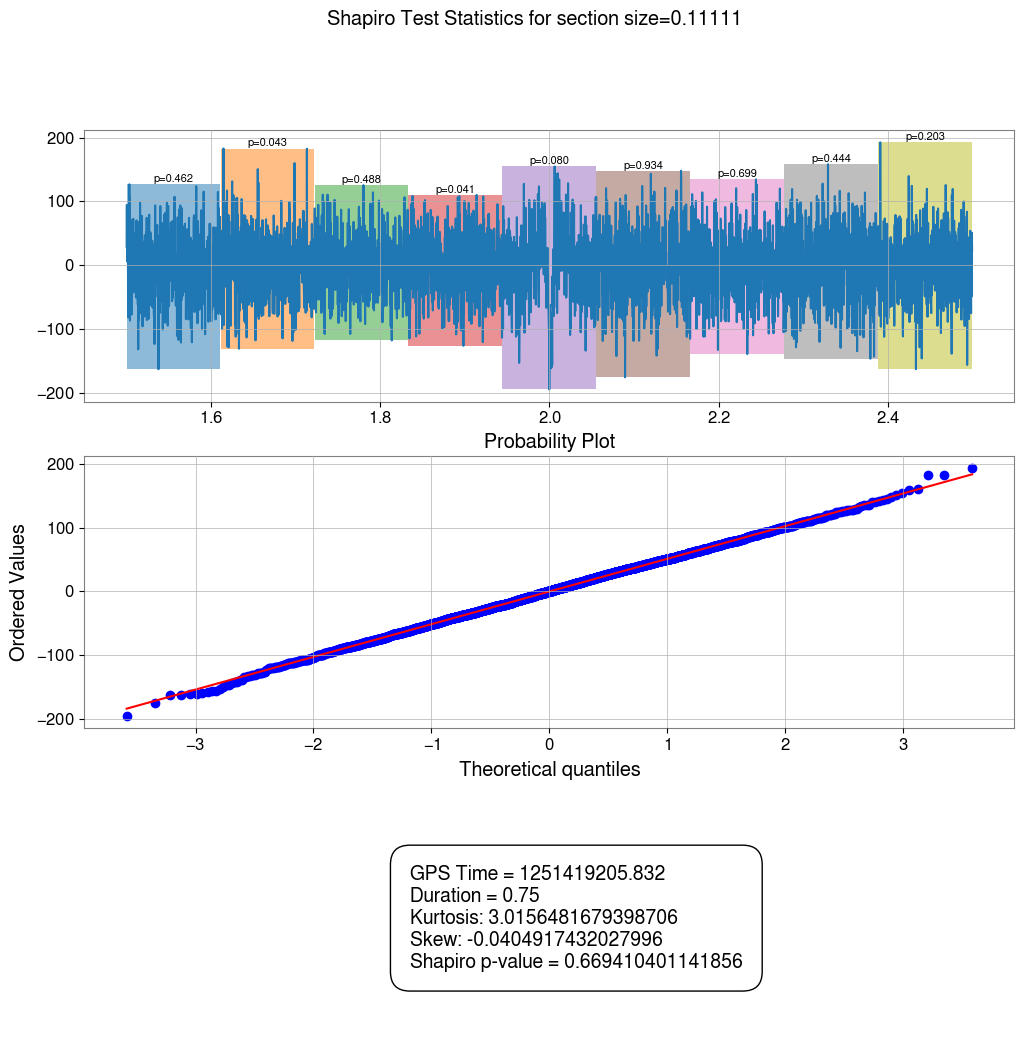

In [38]:
# statistical_testing.display_section_statistics(suspicious_glitch.iloc[0],stat_test="Shapiro", sections=9)
statistical_testing.display_section_statistics(suspicious_glitch.iloc[0],stat_test="Shapiro", section_size_seconds=0.11111) #455 (9)

From the above plots, we see that the Shapiro-Wilk test works well for sections of the glitch samples where it consistently identifies domains not containing the glitch as a 

# Understanding what the Shapiro-Wilk test tries to do

The null hypothesis of this test is that our data comes from a normal distribution. This test only works for univariate, continuous data.

Given a sample $x_{1} \dots x_{n}$, with $n$ as the number of data points the Shapiro-Wilks test statistic is given by $W$ as follows

$$
W = \frac{(\sum_{i=1}^{n}a_{i}x_{(i)})^2}{\sum_{i=1}^{n}(x_i - \bar{x})^2}
$$

If a distribution is normal then, $(\sum_{i=1}^{n}a_{i}x_{(i)})^2$ should be an estimate of the population's variance $\sigma^2$

The denominator here is also an estimation of population variance $\sigma^2$

So, for our null hypothesis to hold true, $W=1$, since the numerator and denominator are both estimating the variance.

For values less than one, it indicates a non-normal distribution

### Issues with this test

- It won't work well if our data has too many equal values
- For a small dataset, our null hypothesis will rarely get rejected
- For a large dataset, our null hypothesis will be rejected for tiny differences from normality

A large p value doesn't prove that a distribution is normal, but that it is not significantly difference from a normal distribution.

### Note

Shapiro Wilks test is too sensitive - a histogram/Q-Q plot should be used when assessing t-test/ANOVA assumptions

### About "a"

Taking the numerator

$$(\sum_{i=1}^{n}a_{i}x_{(i)})^2$$

Here, $x_{(i)}$ are the ["order statistics"](https://youtu.be/gDtkGqLD1R0), that is, the values obtained from the sample when sorted in ascending order.

$a_i$ are constants given by

$$
\frac{m^TV^{-1}}{||V^{-1}m||}
$$

Here, $m$ represents a vector of order statistics we would expect from a standard normal distribution.

$V$ is the covariance matrix given by

$$
V = \mu[X_i - \mu X_i][X_j - \mu X_j]
$$

where $\mu$ is the expected mean of the distribution.

So, for example, if we had two points, $a$ would be $[0.5]$, for 3 points, $[0.375, 0.625]$, for 4 points, $[0.2857, 0.5, 0.7143]$,  and so on.

### Q-Q plots

These plot quantiles of our data vs expected quantiles of a normal distribution.

(Quantile = fraction of points below a given value)
![q-q plot](ad_4nxcrzsncc66mesuuafrmu-n91-w2j72w29cr-sb_o5_9y4k4errnbl3ei0req8twyso1snfa3haoctju5kfnadqygfo0micewassf3ljzvx1thwjgoytvchzbxyqmqdsemaovm7beg.avif)

# More experimentation with the Exponentially weighted averages

A concern I have with exponentially weighted averages is the fact that each of the calculated values depend on a window of values before the current timepoint, hence adding bias to the variance and distribution of every point in the whitened signal. This could lead to a level of non-gaussianity when trying to test our data with the Shapiro-Wilks test. I would like to test this out.

Consider the `example_noise` example from before. Here is what it looks like.

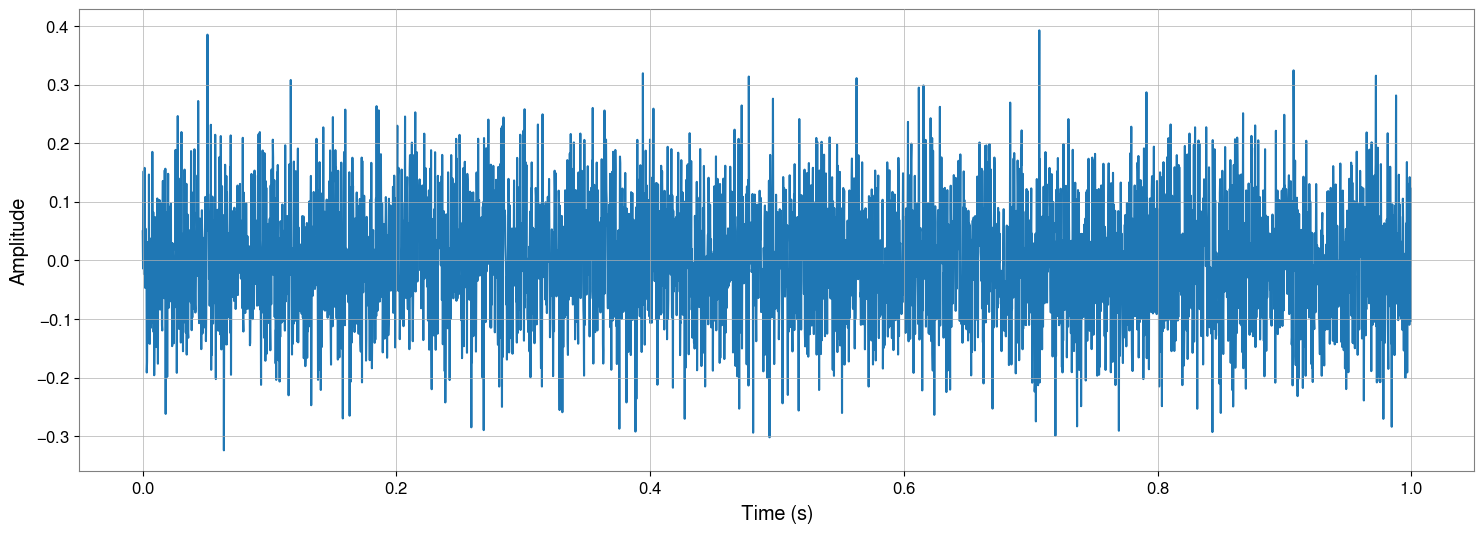

0.7408084478567447


In [39]:
fig = plt.figure(figsize=(18,6))
plt.plot(example_noise)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

print(stats.shapiro(example_noise.value).pvalue)
# warnings.filterwarnings(action='once')

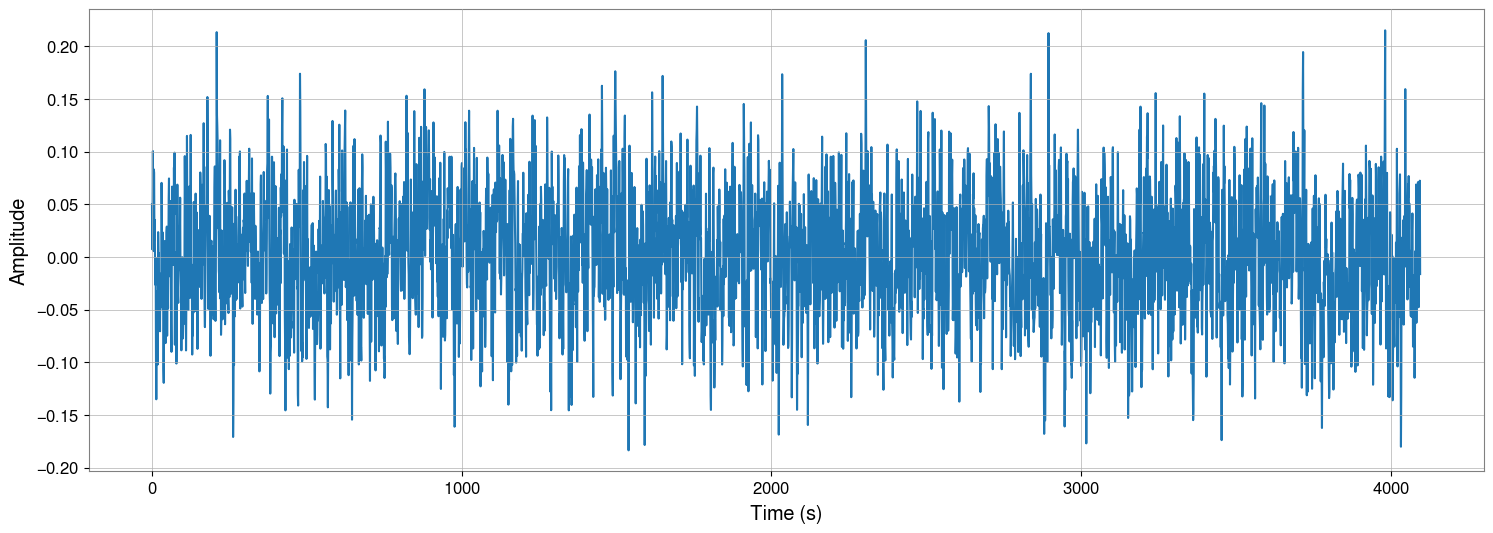

0.6928272690382056


In [40]:
fig = plt.figure(figsize=(18,6))
plt.plot(ewm_example_5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

print(stats.shapiro(ewm_example_5).pvalue)
# warnings.filterwarnings(action='once')


Applying an exponentially weighted average to our data increased the Shapiro test p-value, hence confirming my suspicion. Since exponentially weighted averages supress sudden changes in values, it makes the points seem more uniform than they probably are in reality, hence making this approach unacceptable.

However, I do want to see if this could help a bit when there is a glitch in our data. Since the EWA acts as a low-pass filter of sorts, it can attenuate most high amplitudes, while also introducing a bias. In this case, if there exists a glitch, there is a chance that it could be affected by this, putting more of an emphasis on it (p-value <0.05). 

In [41]:
# fig = plt.figure(figsize=(18,6))
# plt.plot(suspicious_glitch['t'].iloc[0], suspicious_glitch['y'].iloc[0])
# plt.show()

# print(stats.shapiro(suspicious_glitch['y'].iloc[0]).pvalue)

In [42]:
# fig = plt.figure(figsize=(18,6))
# plt.plot(suspicious_glitch['t'].iloc[0],suspicious_glitch['ewm_y'].iloc[0])
# plt.show()

# print(stats.shapiro(suspicious_glitch['ewm_y'].iloc[0]).pvalue)

As expected, this leads to a huge change in the p-value. I want to study this a bit more in detail for all the 50 selected points. 

In [43]:
data_df_tomte['ewm_shapiro_pvalue'] = data_df_tomte['ewm_y'].apply(lambda y: stats.shapiro(y).pvalue)

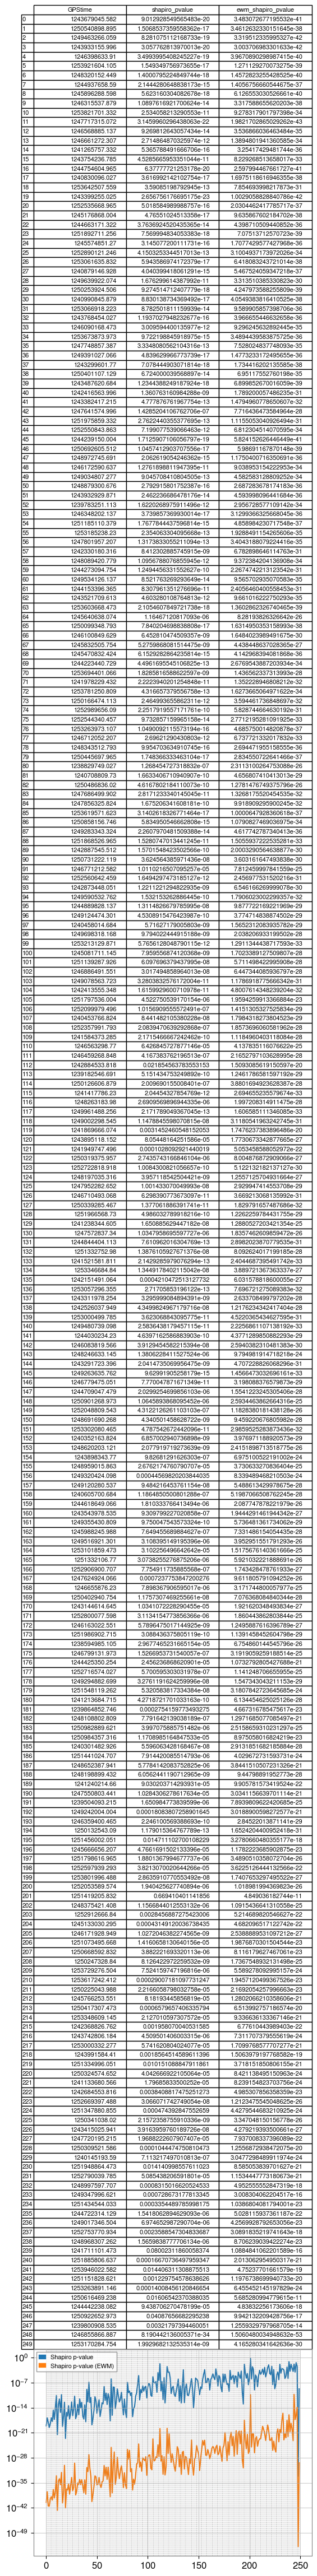

In [44]:
# fig,ax = plt.subplots(figsize=(6,10))
fig,ax = plt.subplots(dpi=100)
plt.plot(data_df_tomte['shapiro_pvalue'], label="Shapiro p-value")
plt.plot(data_df_tomte['ewm_shapiro_pvalue'], label="Shapiro p-value (EWM)")
ax.set_yscale('log')
for i in range(len(data_df_tomte)):
    plt.axvline(x=i, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax.table(cellText=data_df_tomte[['GPStime','shapiro_pvalue','ewm_shapiro_pvalue']].values, colLabels=['GPStime','shapiro_pvalue','ewm_shapiro_pvalue'], rowLabels=data_df_tomte.index, loc='top')
# plt.subplots_adjust(left=0.2, top=0.8)
plt.legend(fontsize=8)
plt.show()

In the above case, we can see that save for a few points, the Shapiro p-values generally have a drastic decrease when the exponentially weighted average is applied to them. This is understandable since we are aware that these samples have a glitch in them.

Below, we perform the same test with a bunch of synthetically generated white noise samples to study whether it has the same effect. The null hyopthesis I have here is that since white noise has several frequencies bounded at the same level of frequencies, the p-value will increase, i.e. all the points in our dataset will be supressed.

In [45]:
def white_noise_shapiro_values(n=50):
    np.random.seed(42)
    noise_df = pd.DataFrame(columns=['TimeSeries', 'EWM TimeSeries', 'shapiro_pvalue', 'ewm_shapiro_pvalue'])
    for i in range(n):
        white_noise = TimeSeries(np.random.normal(scale=.1, size=4096), sample_rate=4096)
        white_noise_ewm = pd.Series(white_noise.value).ewm(0.98).mean()
        noise_df.loc[len(noise_df)] = [white_noise, white_noise_ewm, stats.shapiro(white_noise.value).pvalue, stats.shapiro(white_noise_ewm).pvalue]
    return noise_df


In [46]:
white_noise_examples = white_noise_shapiro_values()

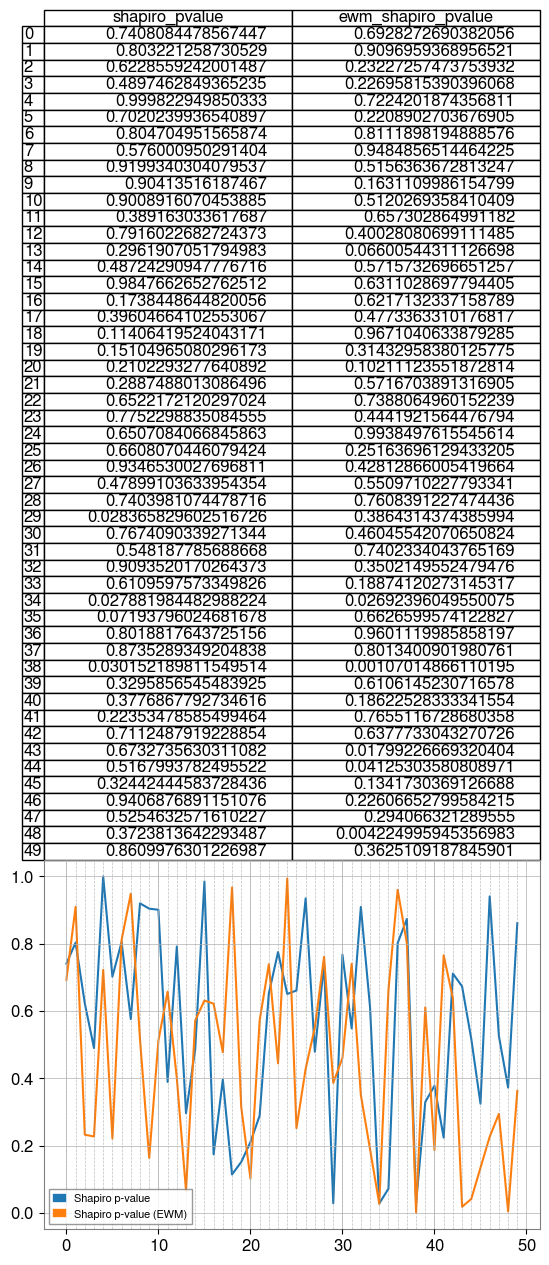

In [47]:
fig,ax = plt.subplots(dpi=100)
plt.plot(white_noise_examples['shapiro_pvalue'], label="Shapiro p-value")
plt.plot(white_noise_examples['ewm_shapiro_pvalue'], label="Shapiro p-value (EWM)")
# ax.set_yscale('log')
for i in range(len(white_noise_examples)):
    plt.axvline(x=i, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax.table(cellText=white_noise_examples[['shapiro_pvalue','ewm_shapiro_pvalue']].values, colLabels=['shapiro_pvalue','ewm_shapiro_pvalue'], rowLabels=white_noise_examples.index, loc='top')
# plt.subplots_adjust(left=0.2, top=0.8)
plt.legend(fontsize=8)
plt.show()

Here we see that even for gaussian noise there can be variations in the Shapiro p-value both below and above the 0.05 threshold

What can be inferred from here is that the exponentially weighted might not be a good approach.

Now I want to shift focus back onto normality testing of our dataset. First I want to start plotting Q-Q plots of the data, starting with the suspicious glitch.

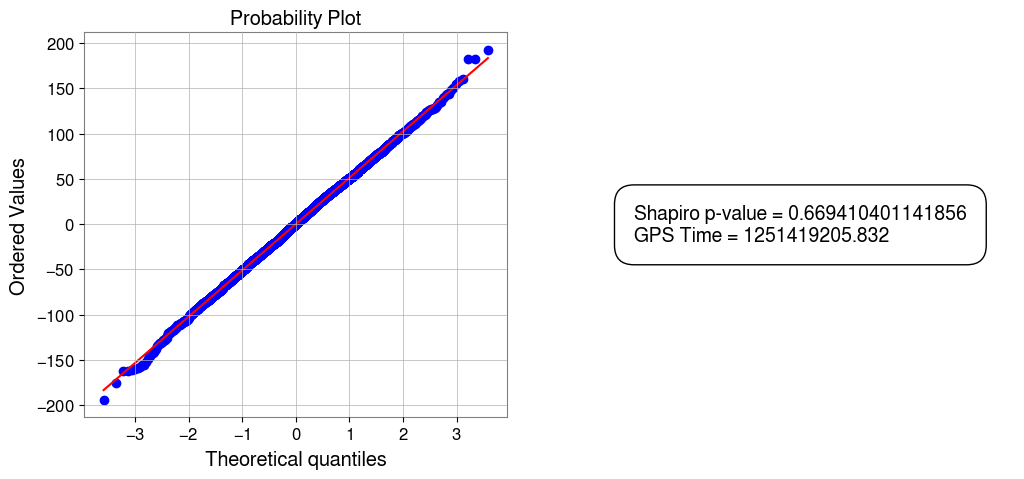

In [48]:
statistical_testing.display_probability_plot(suspicious_glitch.iloc[0])

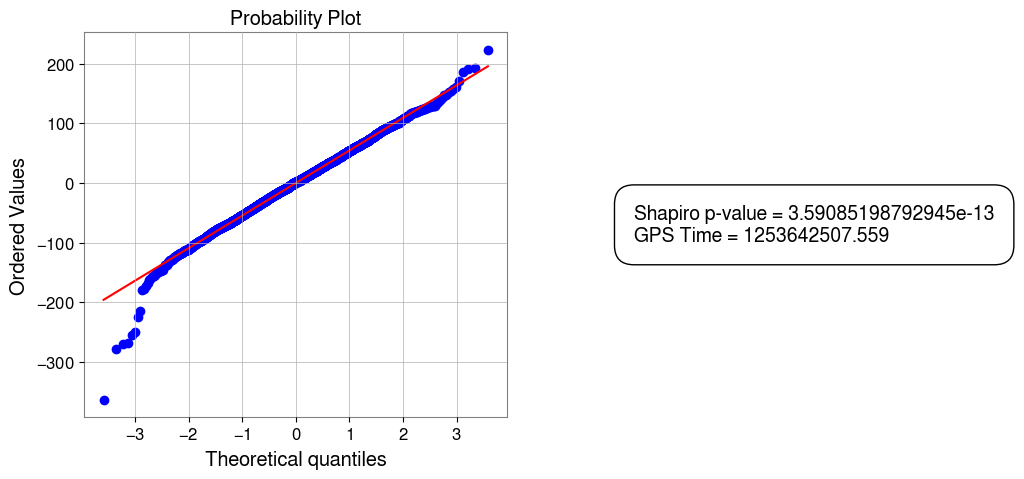

In [49]:
statistical_testing.display_probability_plot(data_df_tomte.iloc[18])

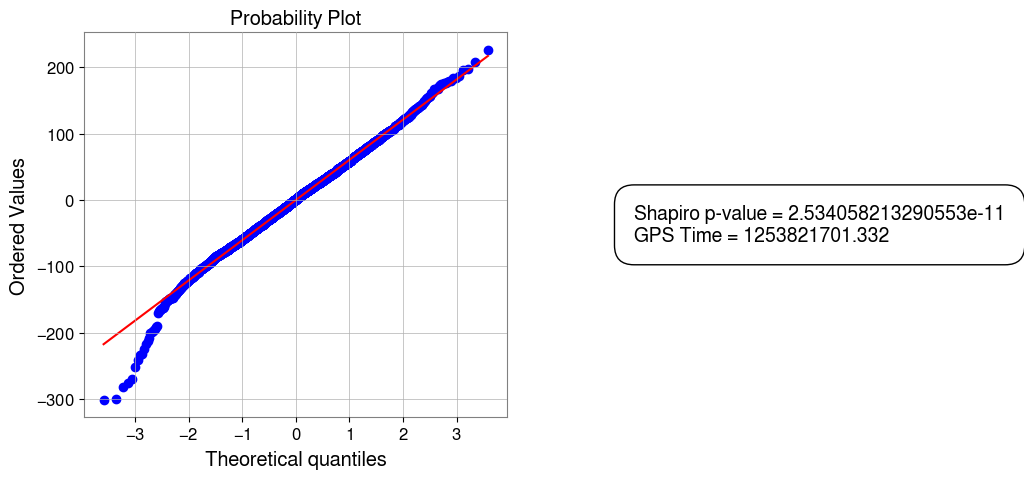

In [50]:
statistical_testing.display_probability_plot(data_df_tomte.iloc[10])

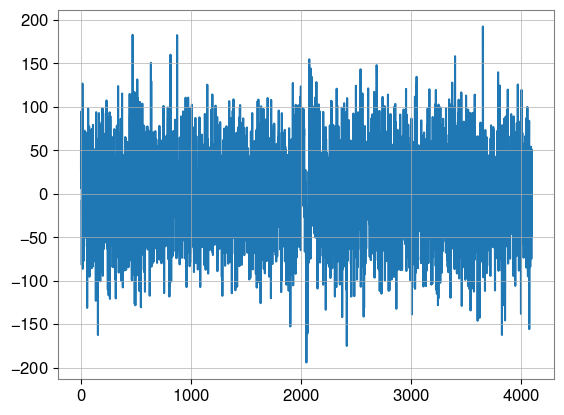

In [51]:
plt.plot(suspicious_glitch['y'].iloc[0])

Shapiro Statistics
0.5117263107415542
0.6406031665278908
0.6065022651262417
0.43619889783731225
0.14883301458994652
0.7150199748177642
0.7643046597825975
0.6046025552130972
0.05022238207035368
0.4112969382885151
0.008997029673009882
0.47432864867123636
0.9117614823270968
0.9370265561399228
0.6864316123345287
0.7148491856387006
0.33410031799436957
0.8053312890655515
0.1562276060151585
0.9355507797200397
0.3243501529347338


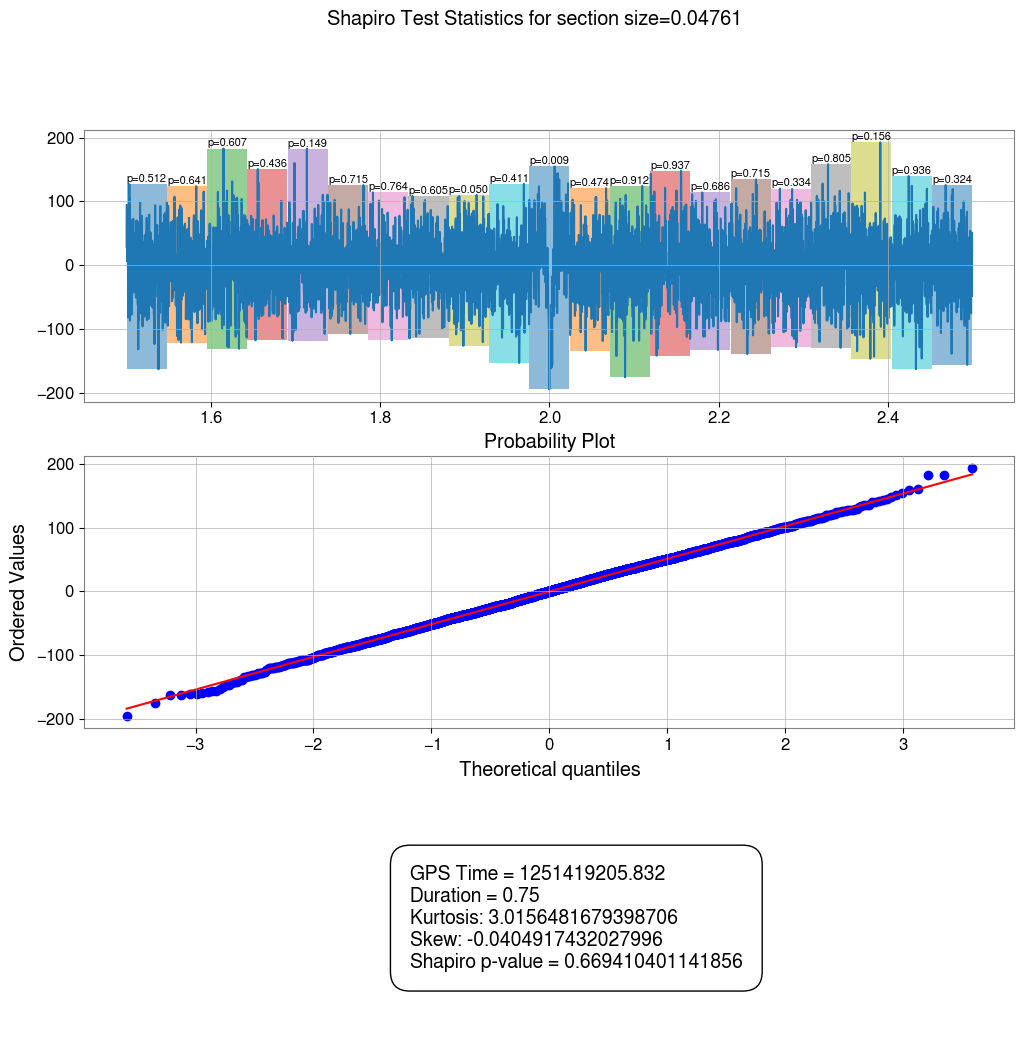

In [52]:
# section_list = statistical_testing.display_section_statistics(suspicious_glitch.iloc[0],stat_test="Shapiro", sections=21)
statistical_testing.display_section_statistics(suspicious_glitch.iloc[0],stat_test="Shapiro", section_size_seconds=0.04761) #195 (21)

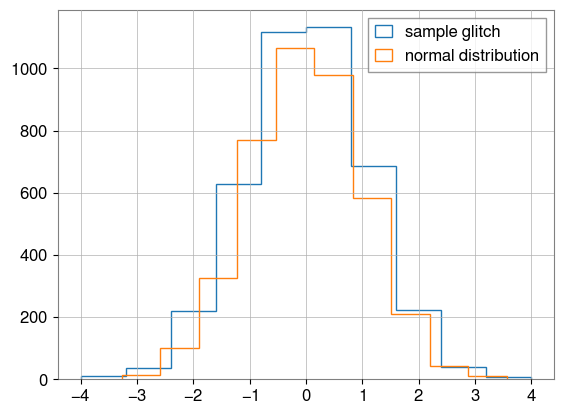

In [53]:
from sklearn.preprocessing import MinMaxScaler

np.random.seed(42)

scaler = MinMaxScaler(feature_range=(-4,4))

plt.hist(list(scaler.fit_transform(suspicious_glitch.iloc[0]["y"].reshape(-1,1))[:,0]), label="sample glitch", histtype='step')
plt.hist(stats.norm.rvs(size=len(suspicious_glitch.iloc[0]["y"]), random_state=np.random.default_rng()), label="normal distribution", histtype='step')
plt.legend()
plt.show()

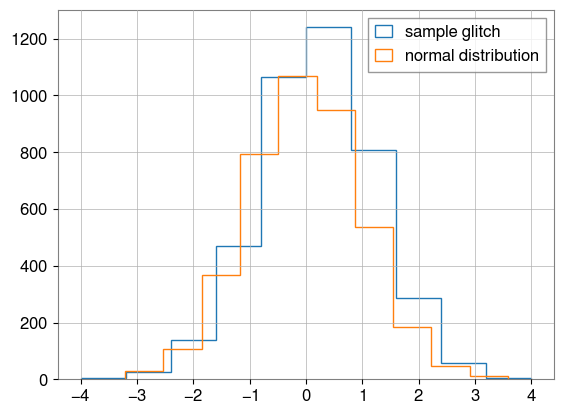

In [54]:
np.random.seed(42)

plt.hist(list(scaler.fit_transform(suspicious_glitch.iloc[1]["y"].reshape(-1,1))[:,0]), label="sample glitch", histtype='step')
plt.hist(stats.norm.rvs(size=len(suspicious_glitch.iloc[1]["y"]), random_state=np.random.default_rng()), label="normal distribution", histtype='step')
plt.legend()
plt.show()

In [55]:
stats.ks_2samp(suspicious_glitch.iloc[0]["y"], stats.norm.rvs(size=len(suspicious_glitch.iloc[0]["y"]), random_state=np.random.default_rng()))

KstestResult(statistic=np.float64(0.48046875), pvalue=np.float64(0.0), statistic_location=np.float64(2.931538519308597), statistic_sign=np.int8(-1))

Anderson Statistics
Section 1: 
AD Statistic= 0.4521946196672957
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 2: 
AD Statistic= 0.25260884588630006
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 3: 
AD Statistic= 0.34006920194147483
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 4: 
AD Statistic= 0.2877907430641926
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 5: 
AD Statistic= 0.2678124069071828
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 6: 
AD Statistic= 0.18820129110713424
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 7: 
AD Statistic= 0.354861908348056
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 8: 
AD Statistic= 0.2260994581353657
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 9: 
AD Statistic= 0.7839781227413027
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 10: 
AD Statistic= 0.4570252510407613
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 11: 
AD Statistic= 0.8473549680674637
C

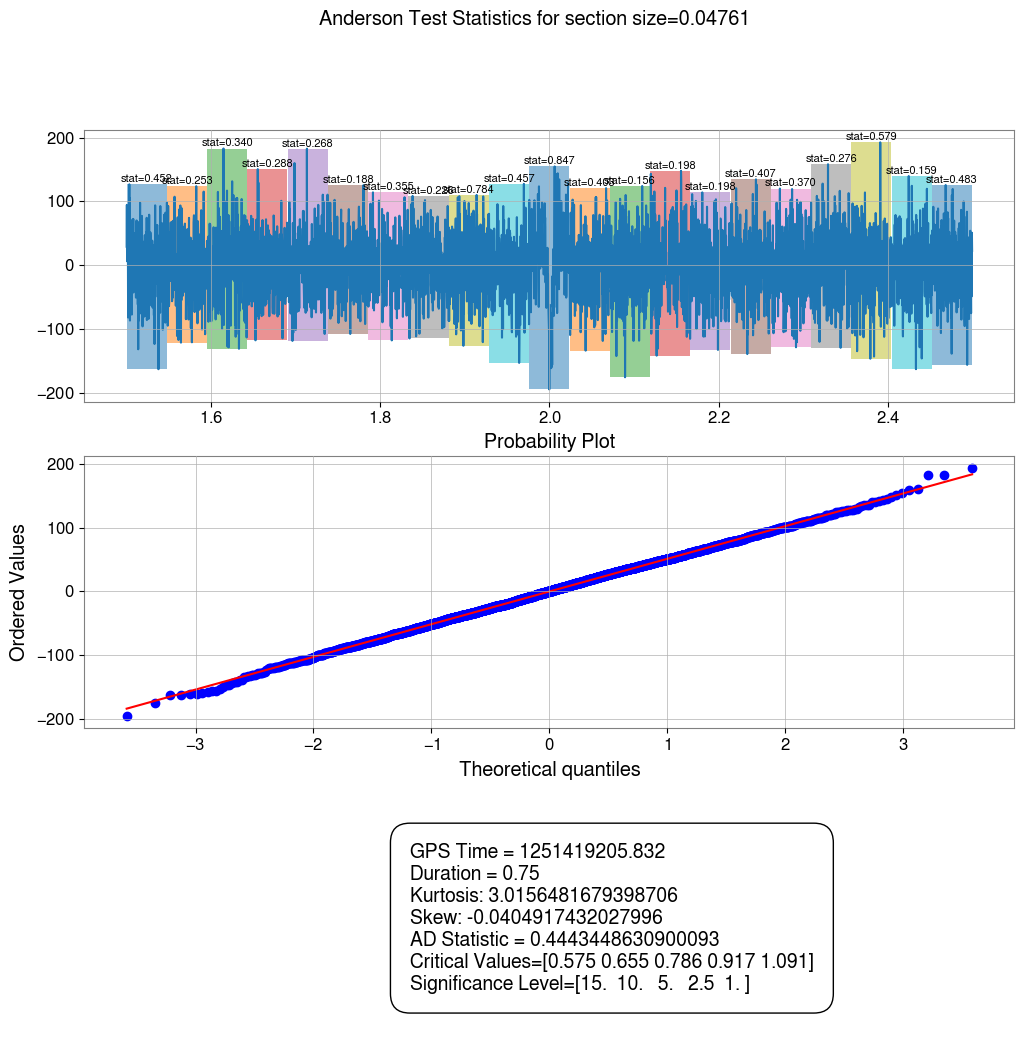

In [56]:
statistical_testing.display_section_statistics(suspicious_glitch.iloc[0],stat_test="Anderson", section_size_seconds=0.04761)

In [57]:
selected.loc[selected["GPStime"] == 1244889828.137]

GPStime      snr  duration  confidence ifo  label
1108 1244889828.13700 21.68400   0.75000     1.00000  L1  Tomte

Shapiro Statistics
0.007999406196905074
1.2447920253953566e-11
0.9266469446195758


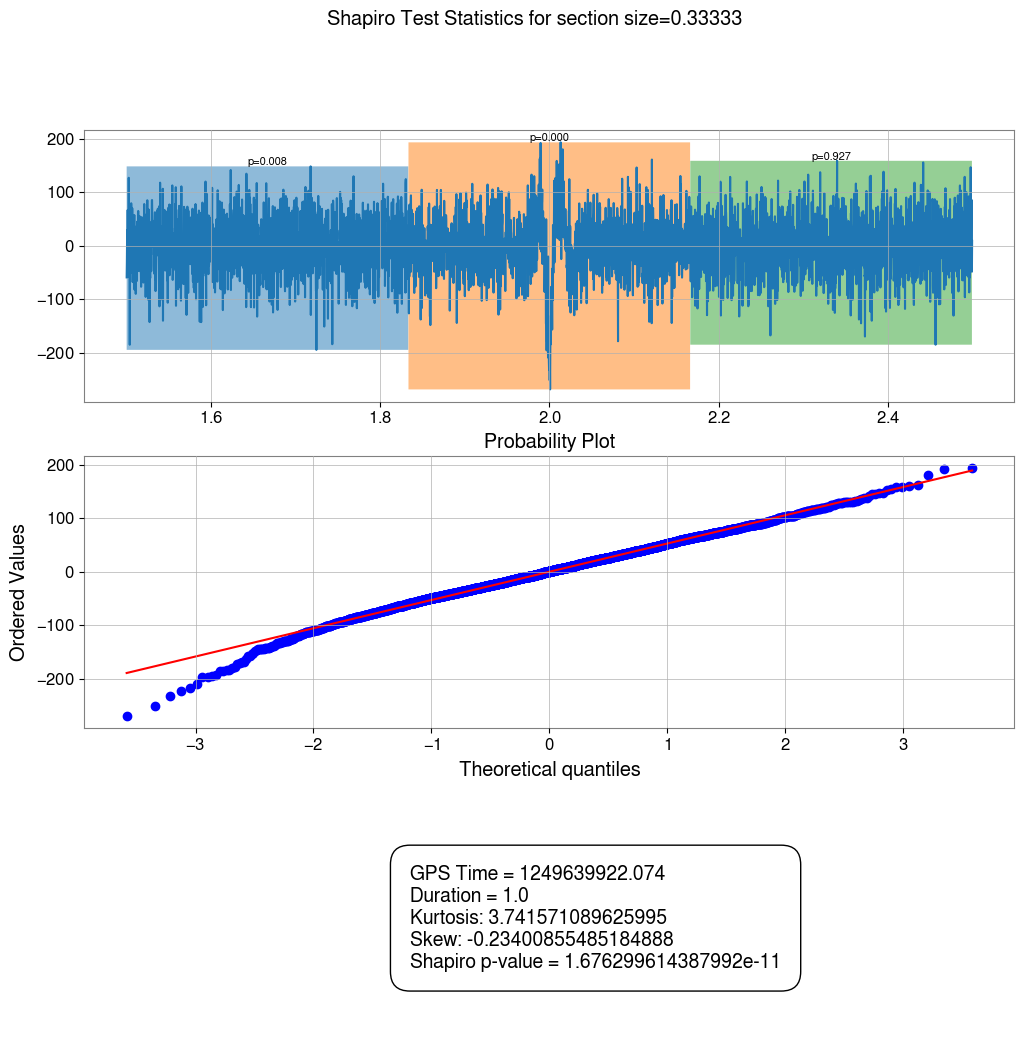

In [58]:
# statistical_testing.display_section_statistics(data_df_tomte.iloc[28],stat_test="Shapiro", sections=3)
statistical_testing.display_section_statistics(data_df_tomte.iloc[28],stat_test="Shapiro", section_size_seconds=0.33333) # (3)

Shapiro Statistics
0.06826640725292318
0.6676624708638199
0.0017766534514462343
0.12218571930761385
1.429519277378946e-07
0.16500004457869627
0.5620211576437247
0.9002527562148424
0.46931423751223783


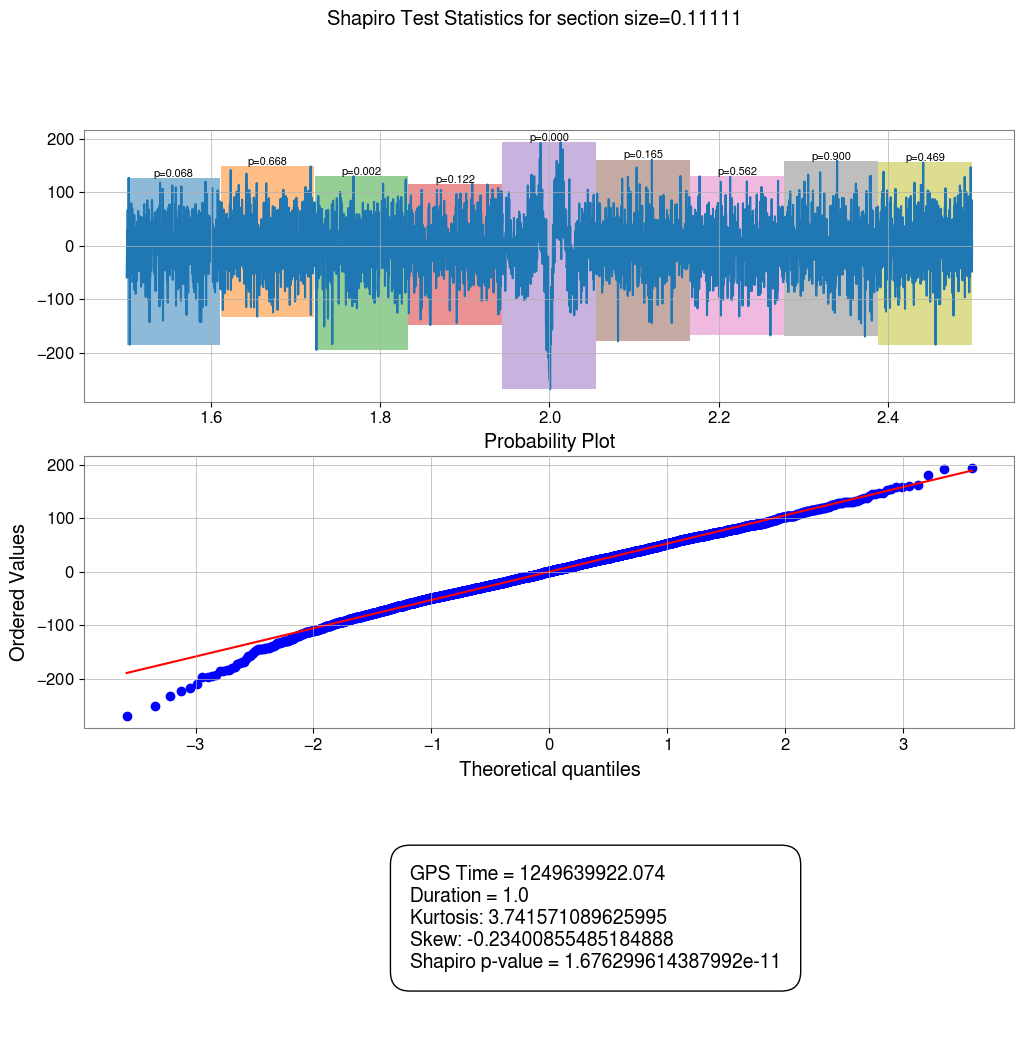

In [59]:
# statistical_testing.display_section_statistics(data_df_tomte.iloc[28],stat_test="Shapiro", sections=9)
statistical_testing.display_section_statistics(data_df_tomte.iloc[28],stat_test="Shapiro", section_size_seconds=0.11111) # (9)

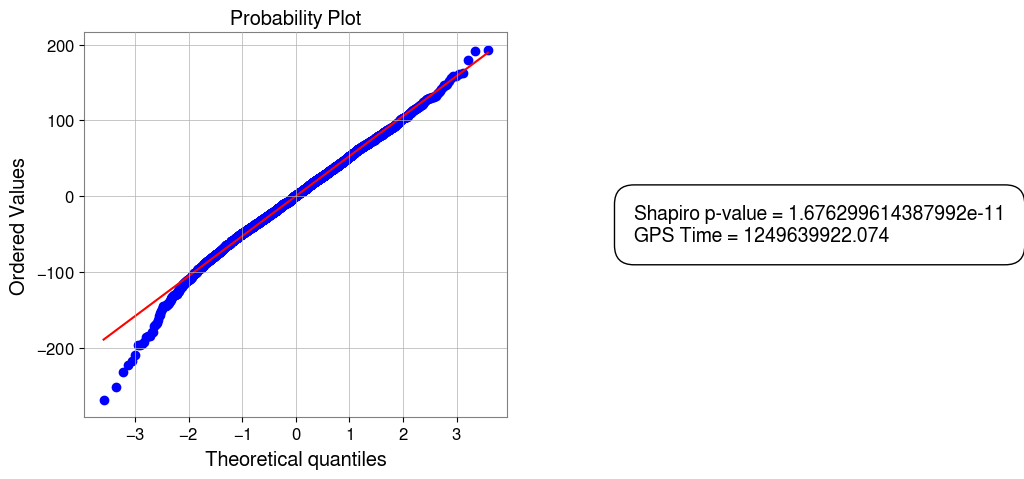

In [60]:
statistical_testing.display_probability_plot(data_df_tomte.iloc[28])

Shapiro Statistics
0.03633743253935452
0.20061105002090962
0.9746120367115085
0.6656373276881953
0.14245345682519678
0.1368681765068857
0.4194658623554793
0.08759577690696387
0.7295471507093468
0.2295473128621875
7.299995823142969e-06
0.197104707350039
0.1496721990377708
0.15322678863891603
0.7375740983409952
0.6006843358702137
0.7353900379149685
0.9241845151735046
0.6680913642726811
0.739670626178806
0.15432104358034837


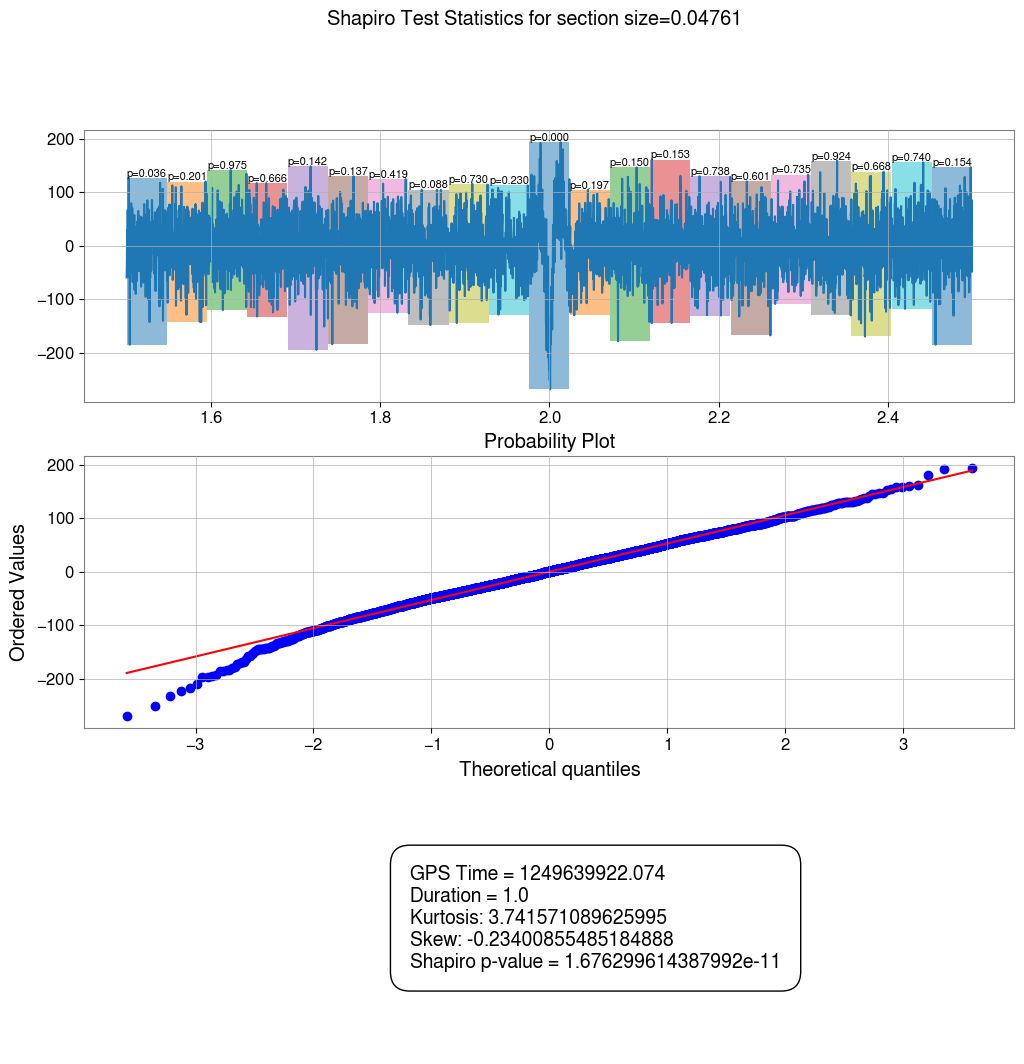

In [61]:
# statistical_testing.display_section_statistics(data_df_tomte.iloc[28],stat_test="Shapiro", sections=21)
statistical_testing.display_section_statistics(data_df_tomte.iloc[28],stat_test="Shapiro", section_size_seconds=0.04761) # (21)

Shapiro Statistics
0.1169462723546798
1.4905421267431142e-12
0.39972266488206143


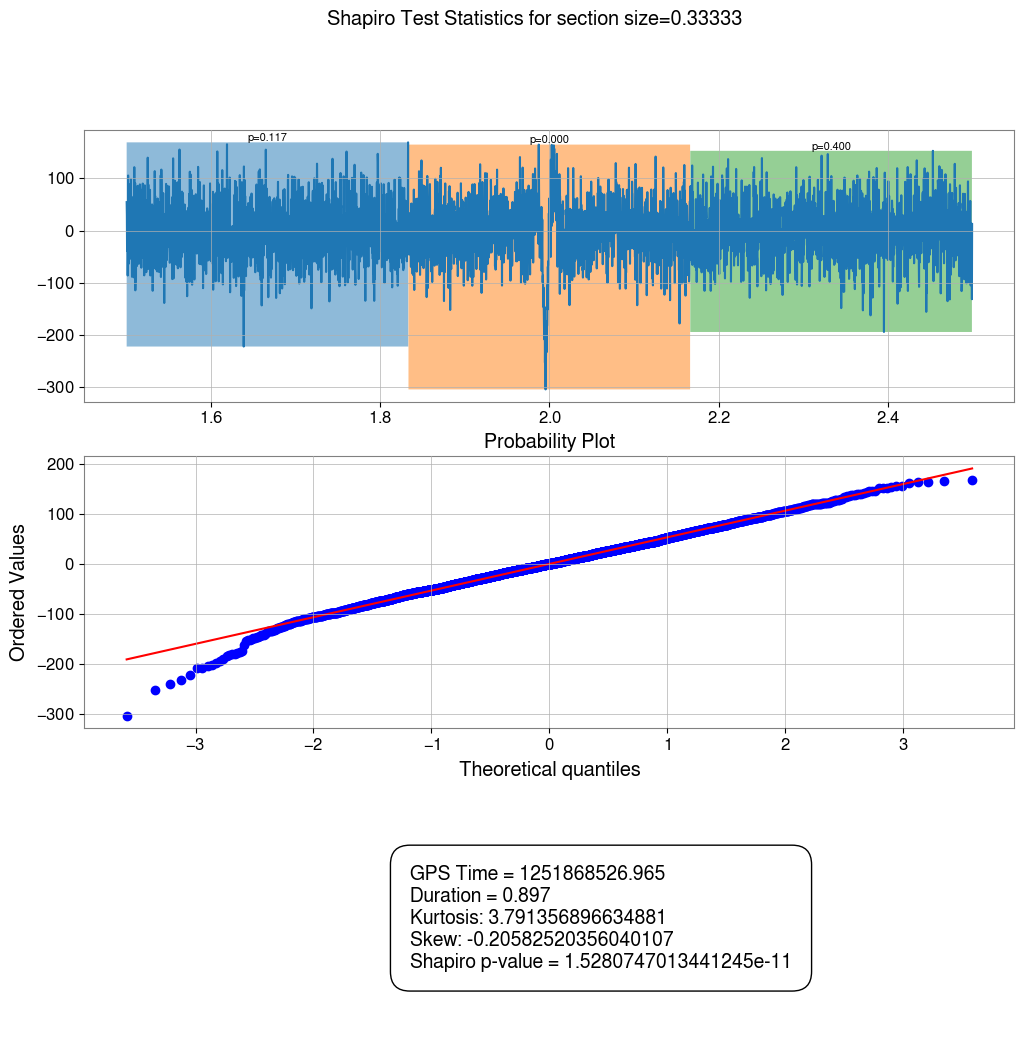

In [62]:
# statistical_testing.display_section_statistics(data_df_tomte.iloc[88],stat_test="Shapiro", sections=9)
statistical_testing.display_section_statistics(data_df_tomte.iloc[88],stat_test="Shapiro", section_size_seconds=0.33333) # (9)

Up to this point I have tested the gitch with a few statistical tests of normality, mainly focusing on the Shapiro-Wilks test. The initial assumption was that the SW test worked well in identifying the 1 second glitch sample to be non-gaussian due to the low p-values. However, on checking the Q-Q plot of the samples against normal distributions, it is found that the samples are actually more akin to gaussian distributions. On testing with smaller chunks of the signal, the Shapiro-Wilks test is able to consistently identify gaussian and non-gaussian sections of the signal.

Hence we see that the test seems to work relatively well when the number of data points per sample is low, however, when we approach a large number of points, say close to 5000, the test fails since the signal represents white noise, giving us a false negatives (Our whitened glitch being identified as gaussian) for a huge portion of our data.

A good use case for what we have experimented with till now could be using the Shapiro on the subsection around our glitch (around 0.25 seconds)

I now want a function which can allow us to study the sample signal using the Shapiro-Wilks, Kolmogorov-Smirnov and Anderson-Darling tests, while also allowing the isolation of the glitched portions of the data for a better understanding of its gaussuanity. I will also be looking at the skewness and kurtosis of our samples to check by how much each sample differs from a normal distribution.

Anderson Statistics
Section 1: 
AD Statistic= 0.24900195996883667
Critical Values=[0.574 0.654 0.785 0.915 1.089]
Section 2: 
AD Statistic= 0.2860264158921382
Critical Values=[0.574 0.654 0.785 0.915 1.089]
Section 3: 
AD Statistic= 0.5376679614996647
Critical Values=[0.574 0.654 0.785 0.915 1.089]


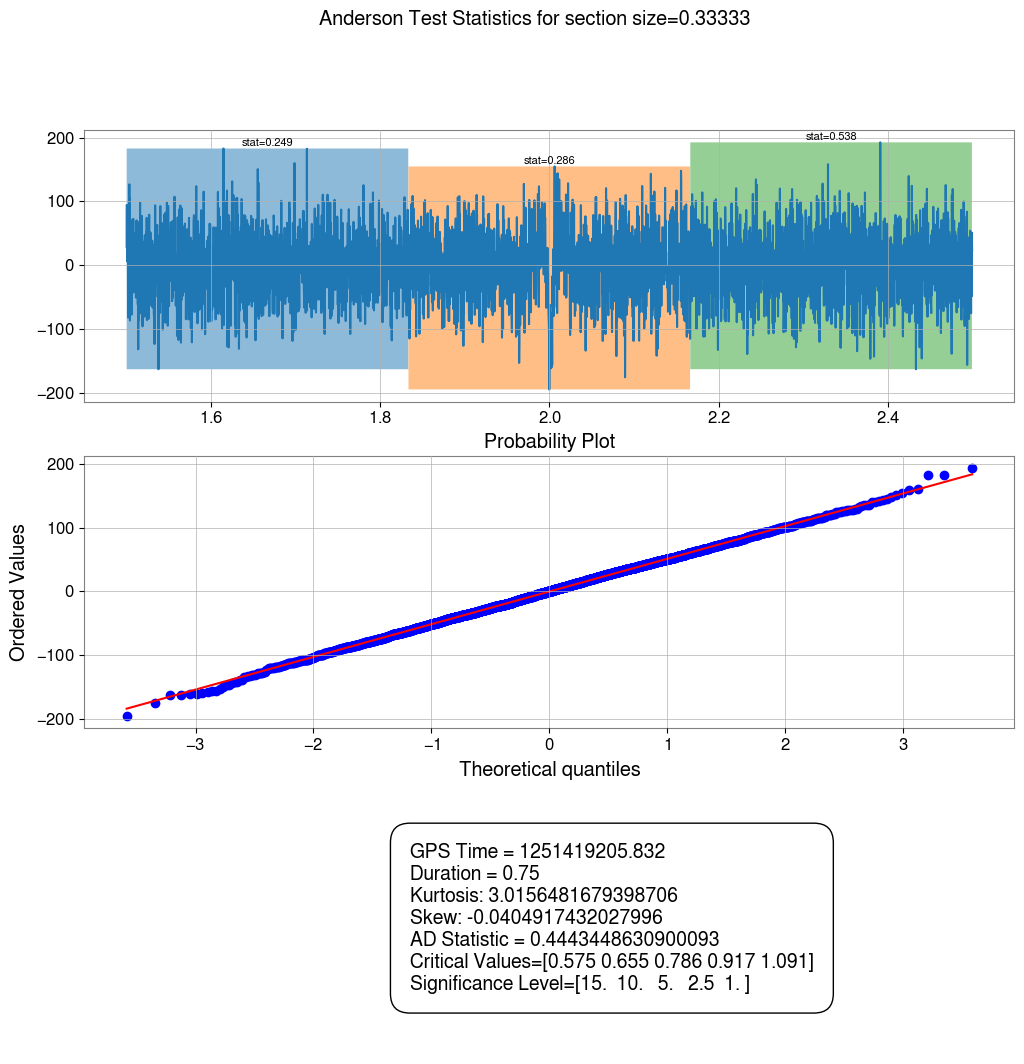

In [63]:
# statistical_testing.display_section_statistics(suspicious_glitch.iloc[0],stat_test="Anderson", sections=9)
statistical_testing.display_section_statistics(suspicious_glitch.iloc[0],stat_test="Anderson", section_size_seconds=0.33333) # (9)

Anderson Statistics
Section 1: 
AD Statistic= 0.5346999236135161
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 2: 
AD Statistic= 0.2801518543927273
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 3: 
AD Statistic= 0.8317907785055354
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 4: 
AD Statistic= 0.3118045807186718
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 5: 
AD Statistic= 3.1416155706232303
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 6: 
AD Statistic= 0.3765897128839697
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 7: 
AD Statistic= 0.32923440565343753
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 8: 
AD Statistic= 0.1846635441436888
Critical Values=[0.571 0.65  0.78  0.91  1.083]
Section 9: 
AD Statistic= 0.5343792682099888
Critical Values=[0.571 0.65  0.78  0.91  1.083]


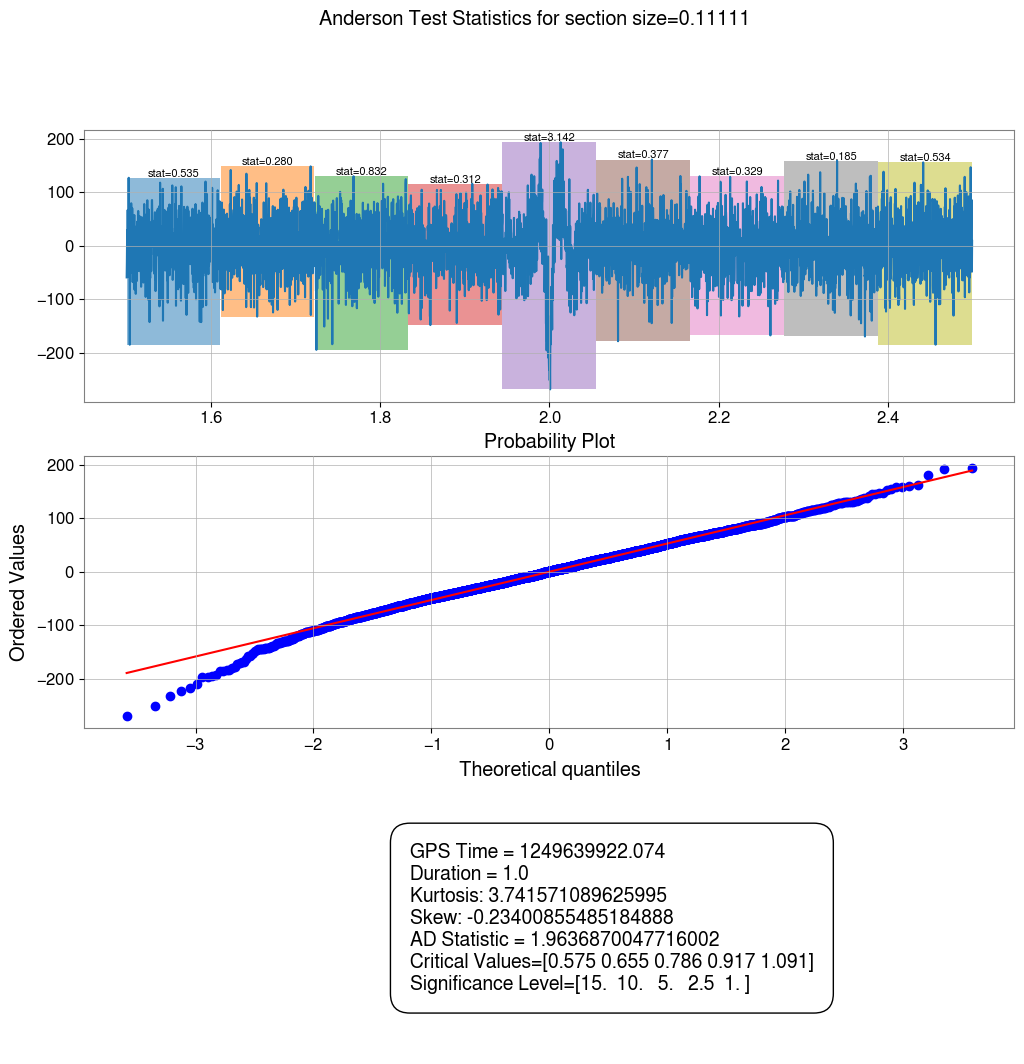

In [64]:
# statistical_testing.display_section_statistics(data_df_tomte.iloc[28],stat_test="Anderson", sections=9)
statistical_testing.display_section_statistics(data_df_tomte.iloc[28],stat_test="Anderson", section_size_seconds=0.11111) # (9)


Anderson Statistics
Section 1: 
AD Statistic= 0.6862705764669954
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 2: 
AD Statistic= 0.5486123877561226
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 3: 
AD Statistic= 0.1673533057136467
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 4: 
AD Statistic= 0.18062383599888676
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 5: 
AD Statistic= 0.36827429329605366
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 6: 
AD Statistic= 0.4635819041329796
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 7: 
AD Statistic= 0.34715382180360166
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 8: 
AD Statistic= 0.41657471041804683
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 9: 
AD Statistic= 0.27403282872882073
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 10: 
AD Statistic= 0.5358995216316202
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 11: 
AD Statistic= 2.851771283264071

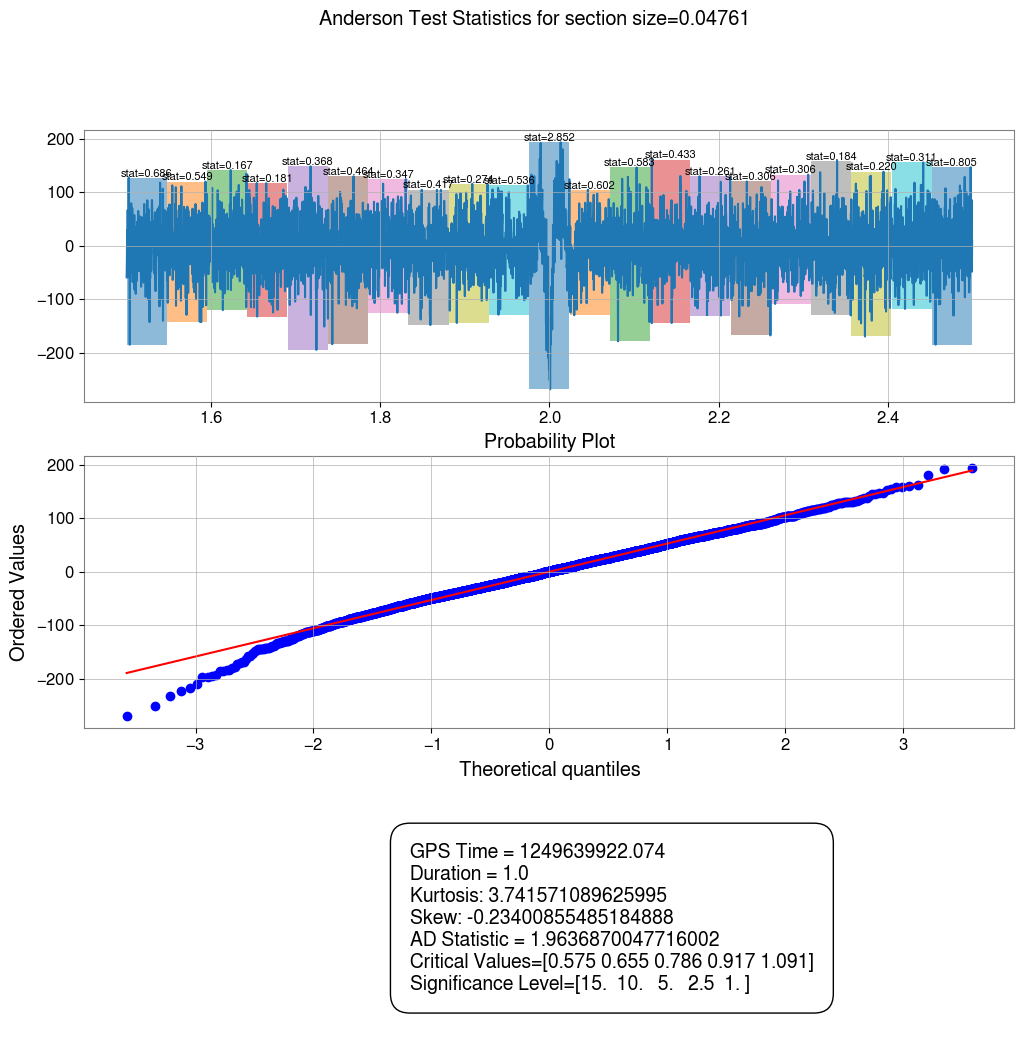

In [65]:
# statistical_testing.display_section_statistics(data_df_tomte.iloc[28],stat_test="Anderson", sections=21)
statistical_testing.display_section_statistics(data_df_tomte.iloc[28],stat_test="Anderson", section_size_seconds=0.04761) # (21)

Anderson Statistics
Section 1: 
AD Statistic= 0.6862705764669954
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 2: 
AD Statistic= 0.5486123877561226
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 3: 
AD Statistic= 0.1673533057136467
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 4: 
AD Statistic= 0.18062383599888676
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 5: 
AD Statistic= 0.36827429329605366
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 6: 
AD Statistic= 0.4635819041329796
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 7: 
AD Statistic= 0.34715382180360166
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 8: 
AD Statistic= 0.41657471041804683
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 9: 
AD Statistic= 0.27403282872882073
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 10: 
AD Statistic= 0.5358995216316202
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 11: 
AD Statistic= 2.851771283264071

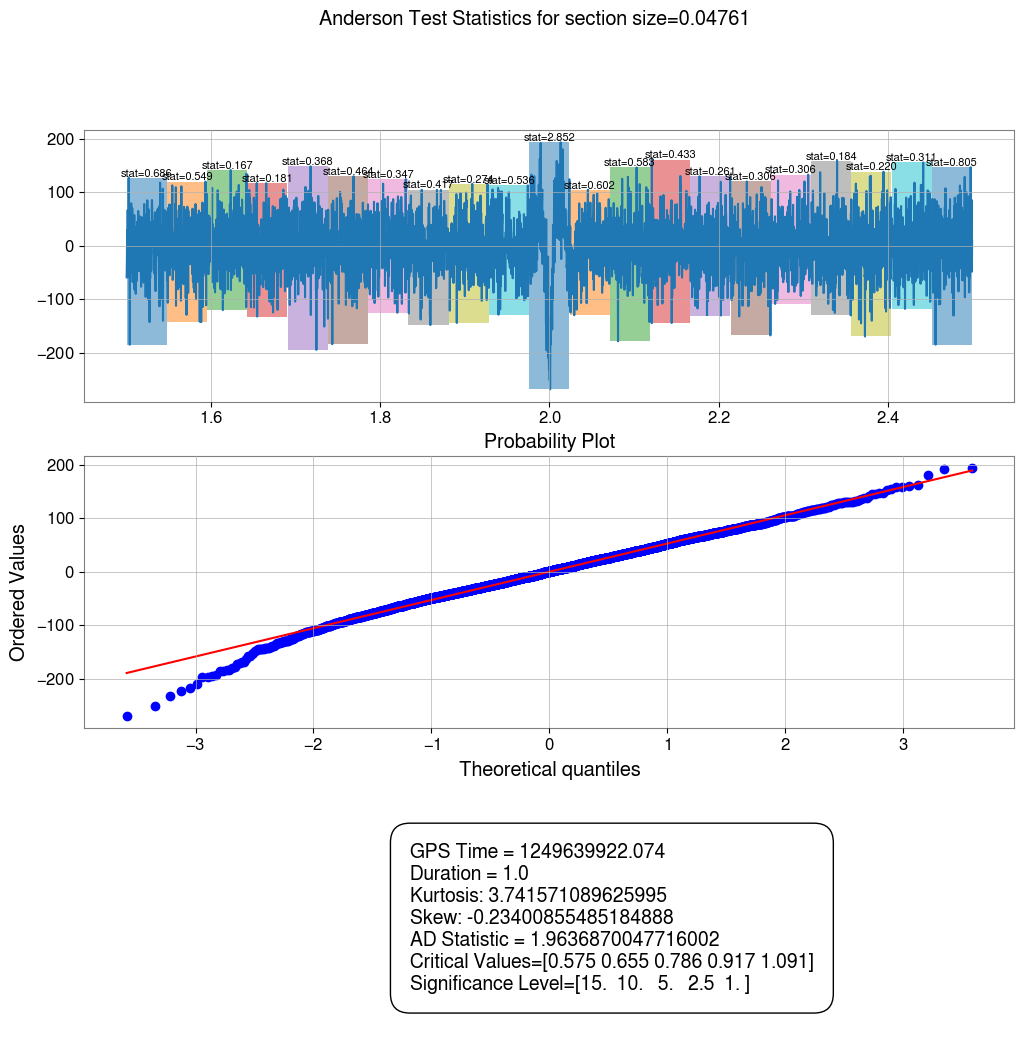

In [66]:
# statistical_testing.display_section_statistics(data_df_tomte.iloc[28],stat_test="Anderson", sections=21)
statistical_testing.display_section_statistics(data_df_tomte.iloc[28],stat_test="Anderson", section_size_seconds=0.04761) # (21) 

Anderson Statistics
Section 1: 
AD Statistic= 0.6862705764669954
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 2: 
AD Statistic= 0.5486123877561226
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 3: 
AD Statistic= 0.1673533057136467
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 4: 
AD Statistic= 0.18062383599888676
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 5: 
AD Statistic= 0.36827429329605366
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 6: 
AD Statistic= 0.4635819041329796
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 7: 
AD Statistic= 0.34715382180360166
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 8: 
AD Statistic= 0.41657471041804683
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 9: 
AD Statistic= 0.27403282872882073
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 10: 
AD Statistic= 0.5358995216316202
Critical Values=[0.565 0.643 0.772 0.9   1.071]
Section 11: 
AD Statistic= 2.851771283264071

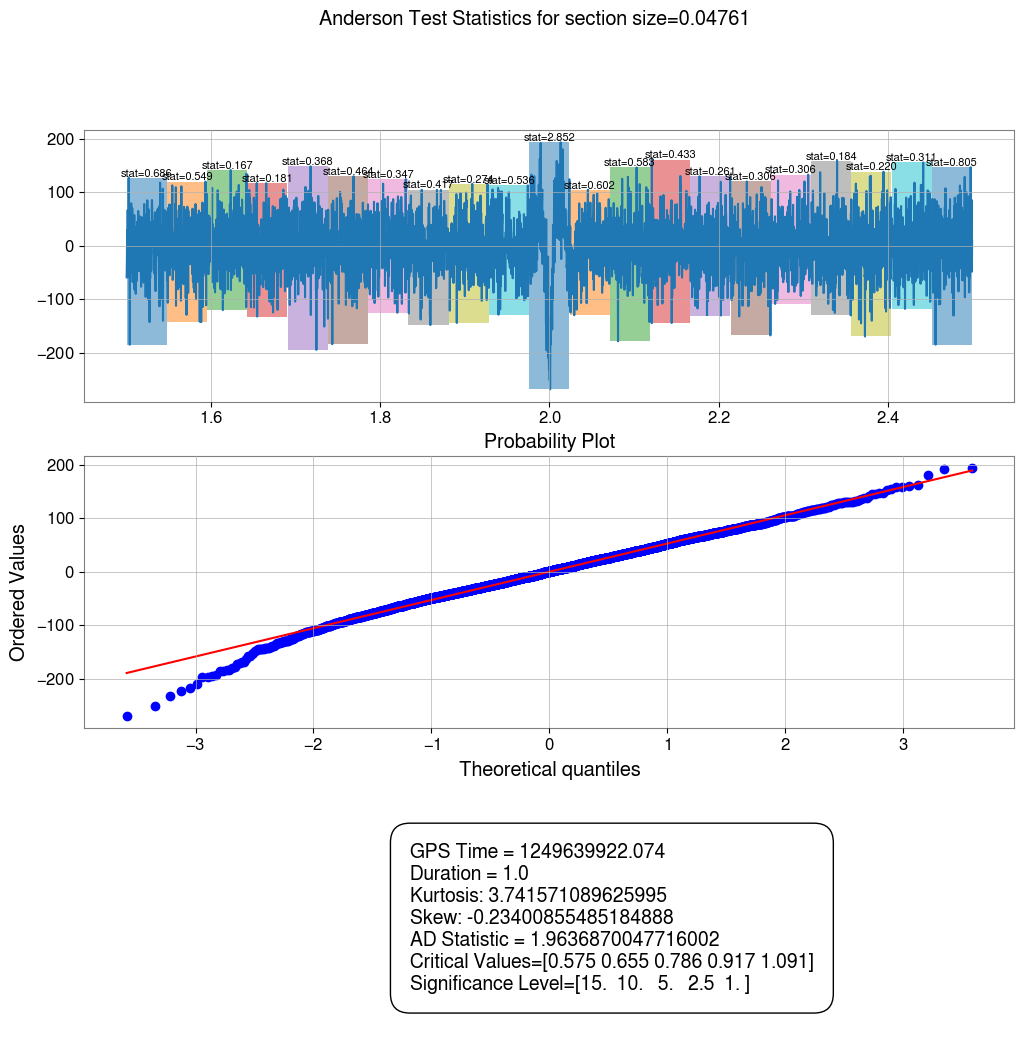

In [67]:
# statistical_testing.display_section_statistics(data_df_tomte.iloc[28],stat_test="Anderson", sections=21)
statistical_testing.display_section_statistics(data_df_tomte.iloc[28],stat_test="Anderson", section_size_seconds=0.04761) # (21)

KS Statistics
2.9336478480614983e-16
5.548241125098516e-05
2.0445133875039553e-24
7.161100453994048e-07
8.415172967738292e-18
0.0012159516301563538
1.2528952857558125e-10
0.019058829063065053
1.0282114822980759e-06
1.0


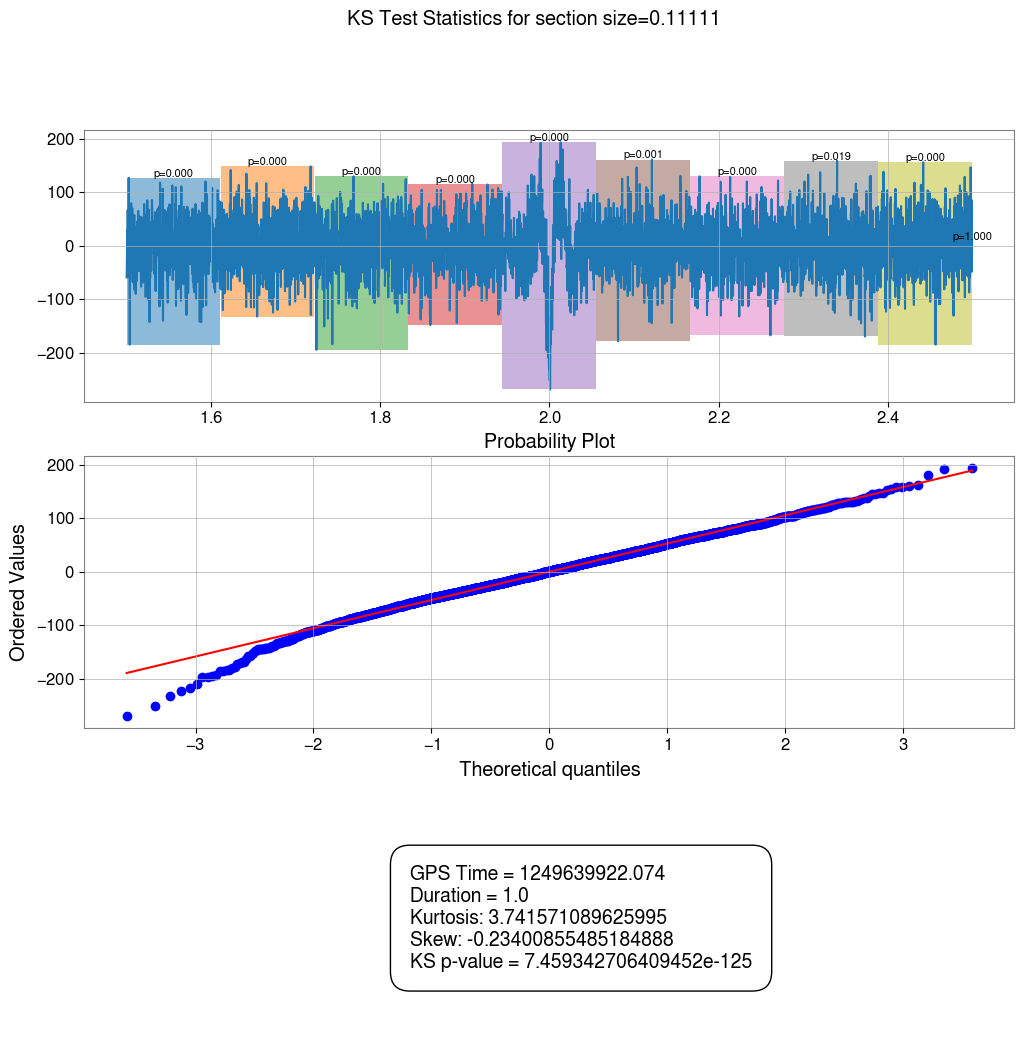

In [68]:
# statistical_testing.display_section_statistics(data_df_tomte.iloc[28],stat_test="KS", sections=9)
statistical_testing.display_section_statistics(data_df_tomte.iloc[28],stat_test="KS", section_size_seconds=0.11111) # (9)

This glitch, for some reason, fails most of the tests. I want to study it a bit.

[This](https://stats.stackexchange.com/questions/20793/what-is-gaussianity-and-how-do-you-perform-gaussianity-testing-in-macroeconom) stackexchange post goes a bit into testing gaussianity for time series information that could be useful. It, however criticizes the approach of using elliptically symmetric distributions (normal distributions) as a way to test gaussianity of a timeseries.

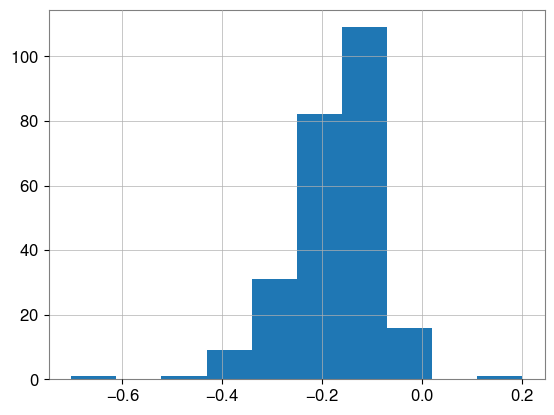

In [69]:
plt.hist(data_df_tomte['skew'])
plt.show()

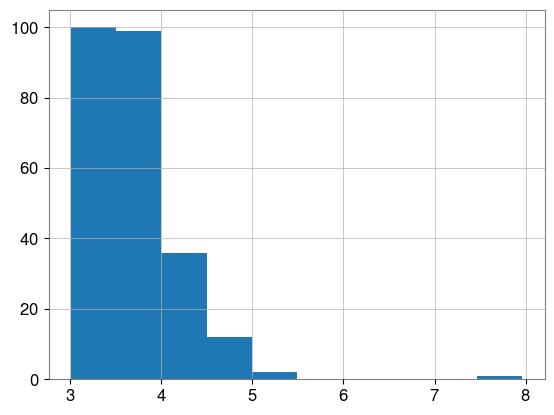

In [70]:
plt.hist(data_df_tomte['kurtosis'])
plt.show()

KS Statistics
7.163412627811192e-19
2.9619779101617324e-06
1.5386981742529825e-20
1.2528952857558125e-10
2.845718717605766e-15
0.11587608223026544
1.980497363885959e-10
0.04967192772510118
0.00018152633121623965
1.0


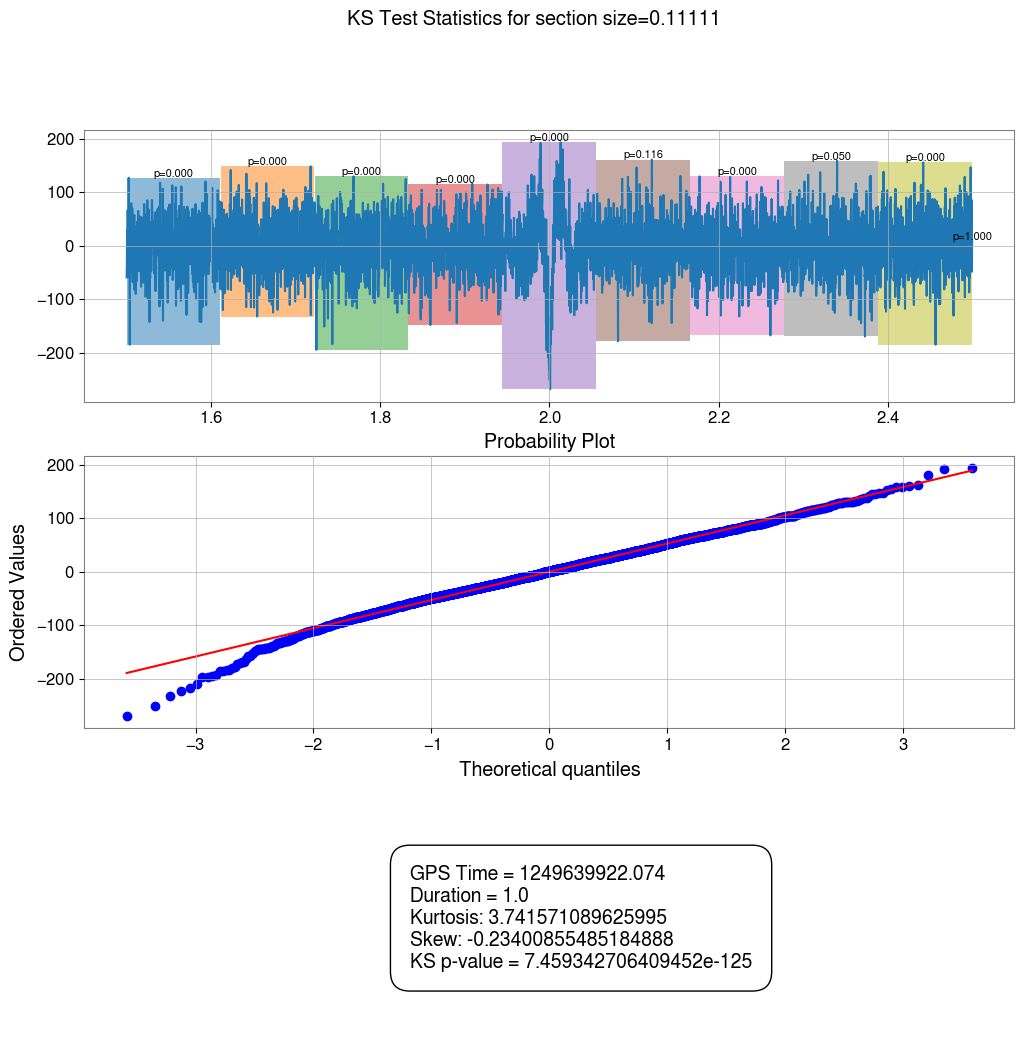

In [71]:
# statistical_testing.section_statistics(data_df_tomte.iloc[28],stat_test="KS", sections=9, display_plots=False)
statistical_testing.display_section_statistics(data_df_tomte.iloc[28],stat_test="KS", section_size_seconds=0.11111) # (9)

Initial statistical testing of the glitches with a time window of 3 seconds showed that the glitch sample at GPS time 1248343512.793 was an outlier. However, this was caused due to the time window in consideration being very small before whitening was performed on the glitch. This led to residual energy peaks disrupting the whitening process for the given sample. This was solved by using a larger window (5 seconds on each side).

In [72]:
outlier_glitch = data_df_tomte.loc[data_df_tomte["GPStime"] == 1248343512.793]

In [73]:
outlier_glitch

GPStime      snr  duration  confidence ifo  label  \
78 1248343512.79300 22.43900   0.87500     1.00000  L1  Tomte   

                                    glitch_timeseries  \
78  [1.0213084965931745e-19, 1.0786808828124569e-1...   

                                                    y  \
78  [44.91379876481842, 51.34791345751043, 16.2015...   

                                                    t  \
78  [1.5 s, 1.500244140625 s, 1.50048828125 s, 1.5...   

                                               q_scan  shapiro_statistic  \
78  [[FrequencySeries(1.6515275\n                u...            0.99072   

    shapiro_pvalue  shapiro_prediction  ks_statistic  ks_pvalue  \
78         0.00000                   1       0.35522    0.00000   

    ks_prediction  ad_statistic                   ad_critical_values  \
78              1       1.71491  [0.575, 0.655, 0.786, 0.917, 1.091]   

          ad_significance_level  kurtosis     skew  \
78  [15.0, 10.0, 5.0, 2.5, 1.0]   4.17562 -0.30074   

                                                ewm_y  \
78  [44.91379876481842, 49.27980516343085, 29.7997...   

                                      ewm_q_transform  ewm_shapiro_pvalue  
78  [[FrequencySeries(0.6880138\n                u...             0.00000

There is one glitch that fails the Shapiro-Wilks test. I want to study this a bit deeper.

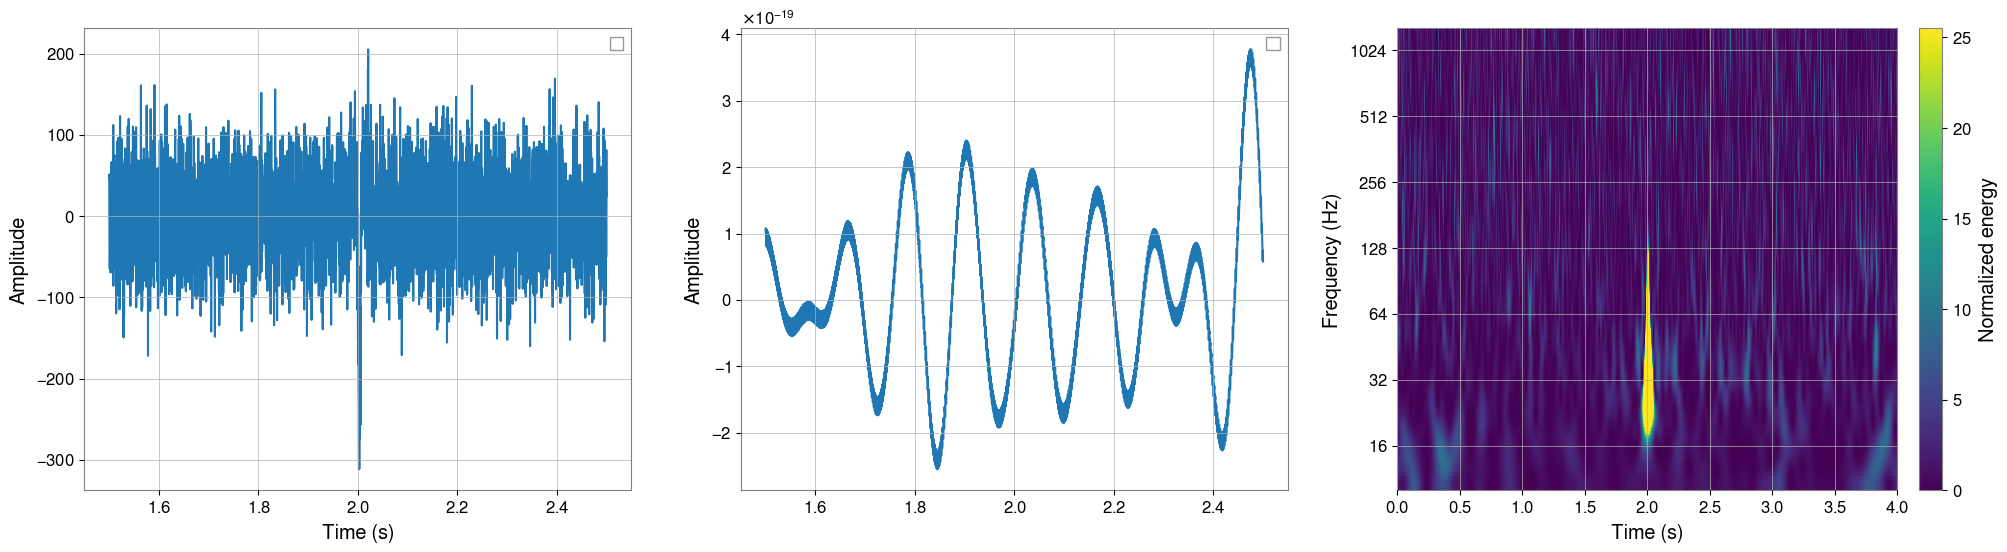

In [74]:
statistical_testing.display_sample_plots(outlier_glitch.iloc[0])

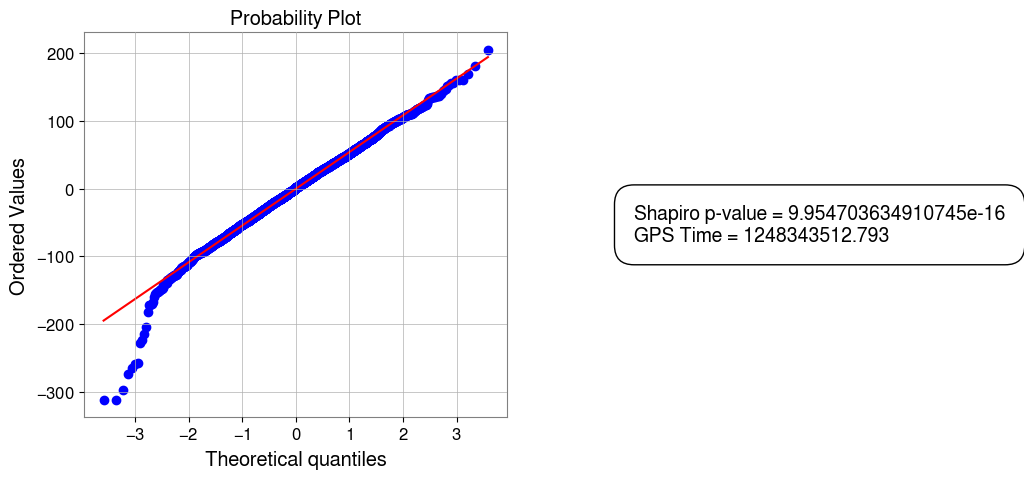

In [75]:
statistical_testing.display_probability_plot(outlier_glitch.iloc[0])

Shapiro Statistics
0.9938705970867199
0.06273589405273938
0.8328168109039058
0.48198433664081225
2.874477850128293e-12
0.7870167476691546
0.853687272048944
0.7994198392827128
0.8756754918434297


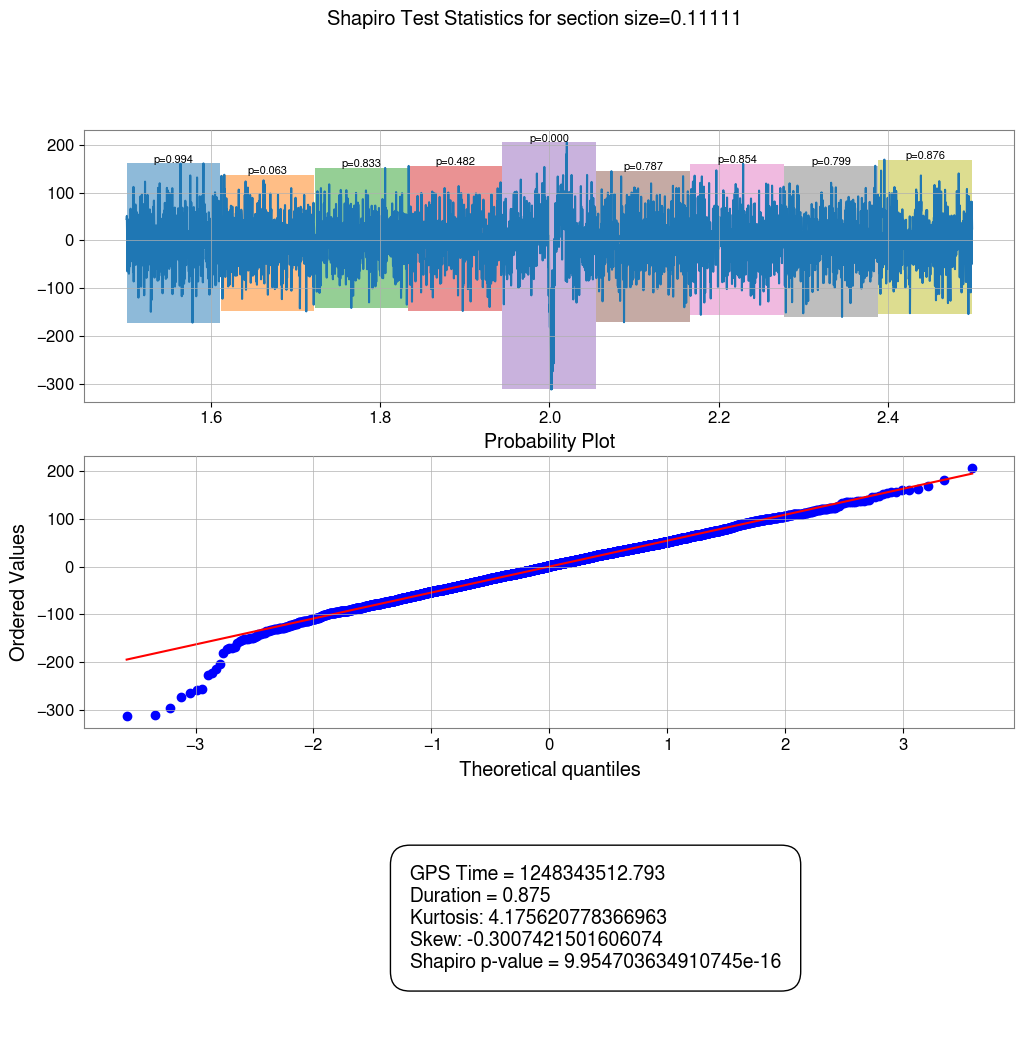

In [76]:
statistical_testing.display_section_statistics(outlier_glitch.iloc[0], section_size_seconds=0.11111)

# Testing GravitySpyTable/EventTable

For the below code to work you will need a few packages to be installed as follows

```bash
pip install sqlalchemy dotenv psycopg2
```

In [77]:
# import os
# from dotenv import find_dotenv,load_dotenv
# from gwpy.table import EventTable
# from gwpy.table import GravitySpyTable

# load_dotenv(find_dotenv(), verbose=True)

For the code from here on out to work, you will need to use `.env` files to load a username and password unique to you. Make a `.env` file in the same folder as this notebook with the following information

```env
GRAVITYSPY_DATABASE_USER='username'
GRAVITYSPY_DATABASE_PASSWD='password'
```

The code below adds the GravitySpy database username and password from the .env file to your system environment variable which can then be used by `GravitySpyTable` to authenticate you as a valid LIGO member accessing the information. More information on this can be found in the [documentation](https://gwpy.github.io/docs/latest/table/io/)

In [78]:
# GRAVITYSPY_DATABASE_USER = os.getenv('GRAVITYSPY_DATABASE_USER')
# GRAVITYSPY_DATABASE_PASSWD = os.getenv('GRAVITYSPY_DATABASE_PASSWD')

Now that the above cell has been run, we can now access the dataset of our choice as follows.

In [79]:
# if not os.path.exists("./gspy_glitches"):
#     os.makedirs("./gspy_glitches")
# if not os.path.exists("./gspy_glitches/gspy_tomtes.csv"):
#     tomtes = GravitySpyTable.fetch(
#         "gravityspy",
#         "glitches",
#         selection="ml_label=Tomte"
#     ).to_pandas()
#     tomtes.to_csv("gspy_glitches/gspy_tomtes.csv", index=False)

In [80]:
# if not os.path.exists("./gspy_glitches"):
#     os.makedirs("./gspy_glitches")
# if not os.path.exists("./gspy_glitches/gspy_extremely_loud.csv"):
#     extremely_loud = GravitySpyTable.fetch(
#         "gravityspy",
#         "glitches",
#         selection="ml_label=Extremely_Loud"
#     ).to_pandas()
#     extremely_loud.to_csv("gspy_glitches/gspy_extremely_loud.csv", index=False)

Hence, loading up datasets from GravitySpy is much easier than anticipated.

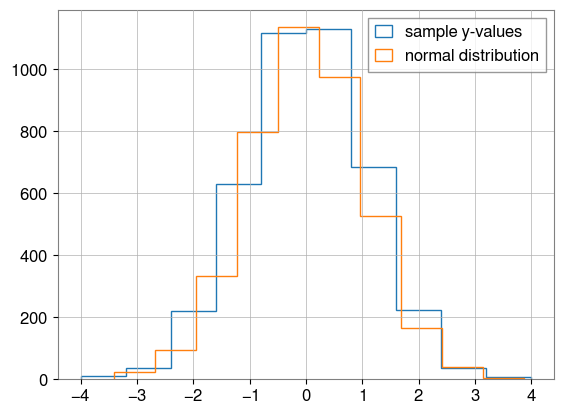

In [81]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-4,4))
# fig,ax = plt.subplots(figsize=(6,10))

fig = plt.figure(dpi=100)
plt.hist(scaler.fit_transform(suspicious_glitch['y'].iloc[0].reshape(-1,1)), label="sample y-values", histtype='step')
plt.hist(stats.norm.rvs(size=len(suspicious_glitch['y'].iloc[0]), random_state=np.random.default_rng()), label="normal distribution", histtype='step')
plt.legend()
plt.show()

In [82]:
suspicious_glitch

GPStime      snr  duration  confidence ifo  label  \
201 1251419205.83200 18.00100   0.75000     1.00000  L1  Tomte   
239 1241711101.47300 16.08900   0.43900     1.00000  L1  Tomte   

                                     glitch_timeseries  \
201  [-1.3597081426545253e-20, -9.31465196867568e-2...   
239  [-2.0746733557404072e-19, -2.1288199654571774e...   

                                                     y  \
201  [29.16121667375581, 94.66529378808767, 6.32355...   
239  [16.222474333849448, 29.36424586029554, 80.278...   

                                                     t  \
201  [1.5 s, 1.500244140625 s, 1.50048828125 s, 1.5...   
239  [1.5 s, 1.500244140625 s, 1.50048828125 s, 1.5...   

                                                q_scan  shapiro_statistic  \
201  [[FrequencySeries(1.3943119\n                u...            0.99963   
239  [[FrequencySeries(0.18476272\n                ...            0.99924   

     shapiro_pvalue  shapiro_prediction  ks_statistic  ks_pvalue  \
201         0.66941                   0       0.02515    0.14997   
239         0.08002                   0       0.08325    0.00000   

     ks_prediction  ad_statistic                   ad_critical_values  \
201              0       0.44434  [0.575, 0.655, 0.786, 0.917, 1.091]   
239              1       0.44943  [0.575, 0.655, 0.786, 0.917, 1.091]   

           ad_significance_level  kurtosis     skew  \
201  [15.0, 10.0, 5.0, 2.5, 1.0]   3.01565 -0.04049   
239  [15.0, 10.0, 5.0, 2.5, 1.0]   3.12963 -0.09342   

                                                 ewm_y  \
201  [29.16121667375581, 73.61041185848099, 33.9847...   
239  [16.222474333849448, 25.14010501250929, 57.611...   

                                       ewm_q_transform  
201  [[FrequencySeries(1.6861959\n                u...  
239  [[FrequencySeries(1.4850954\n                u...

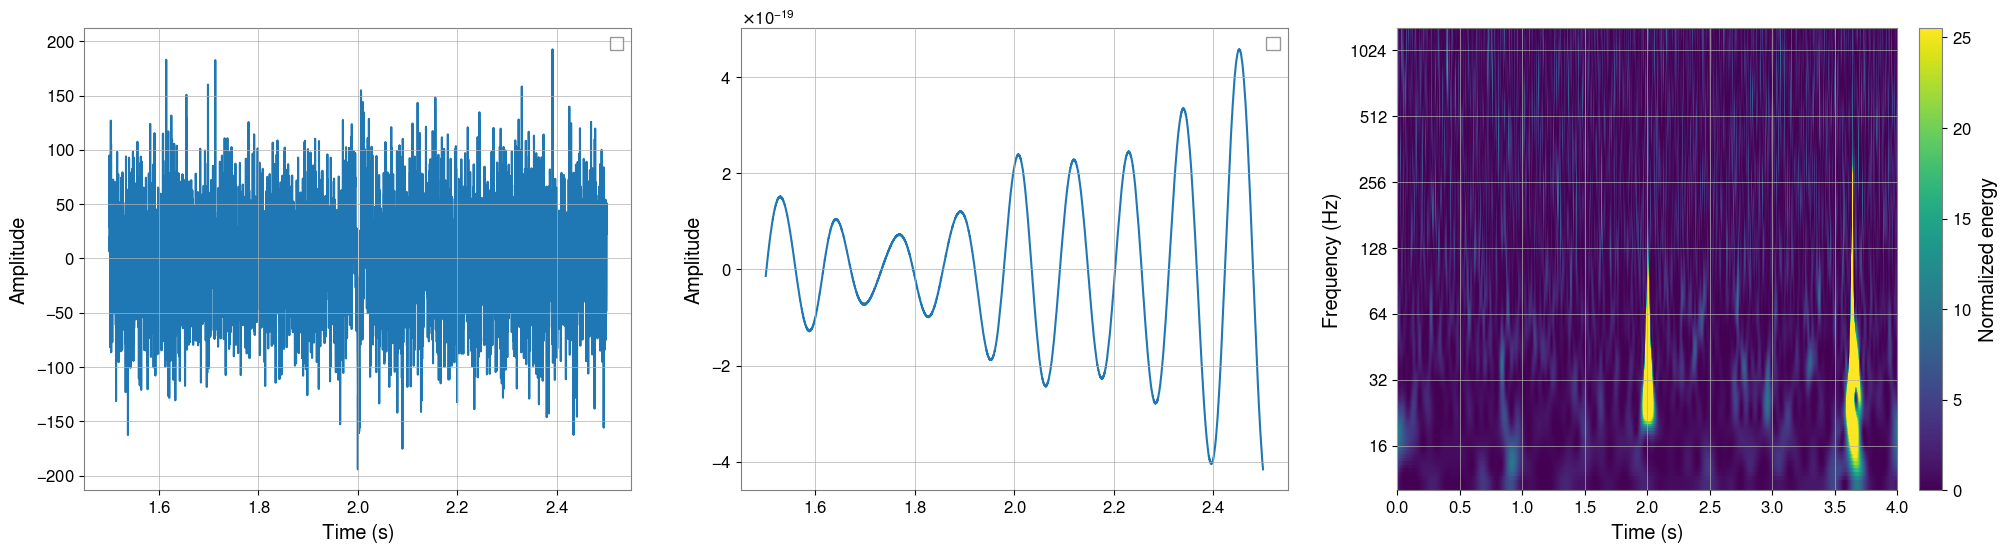

In [83]:
statistical_testing.display_sample_plots(suspicious_glitch.iloc[0])

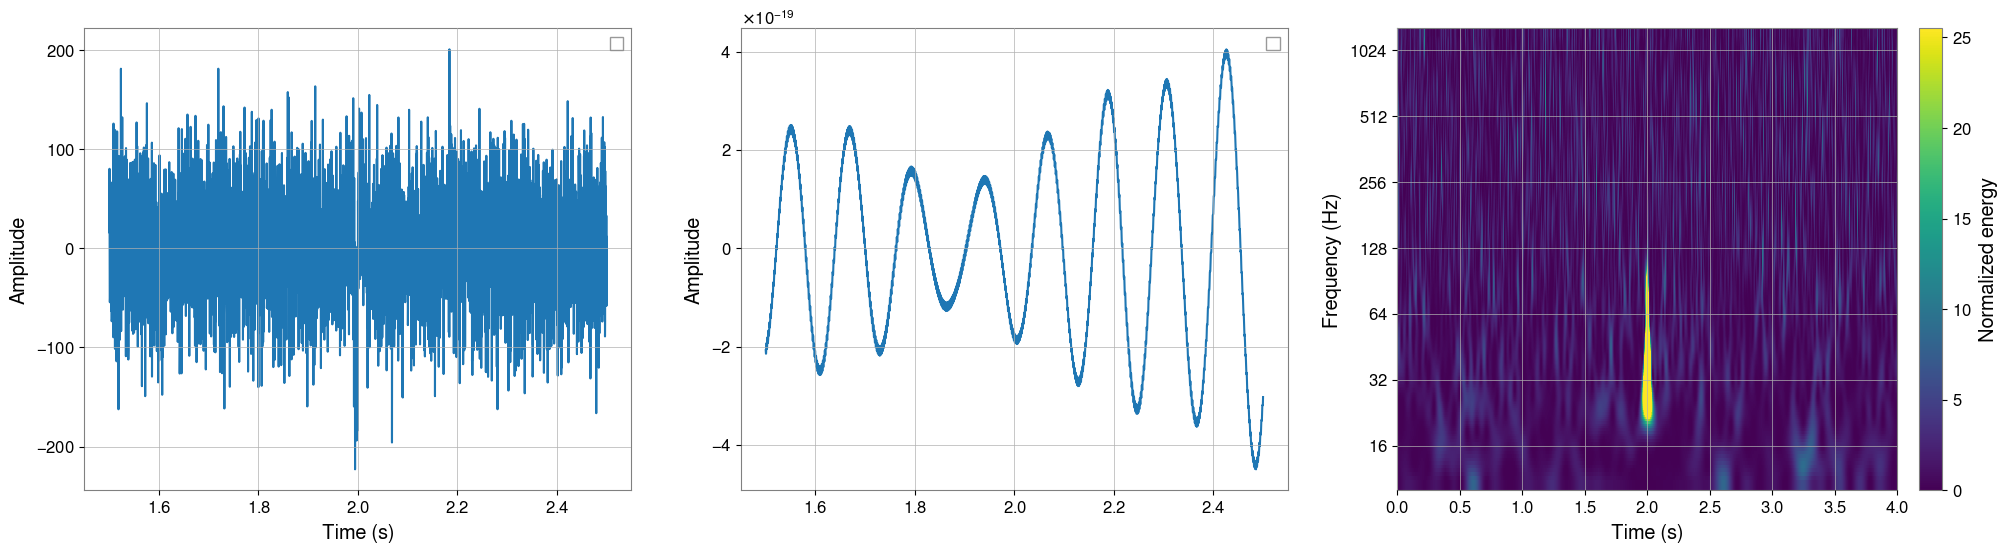

In [84]:
statistical_testing.display_sample_plots(suspicious_glitch.iloc[1])

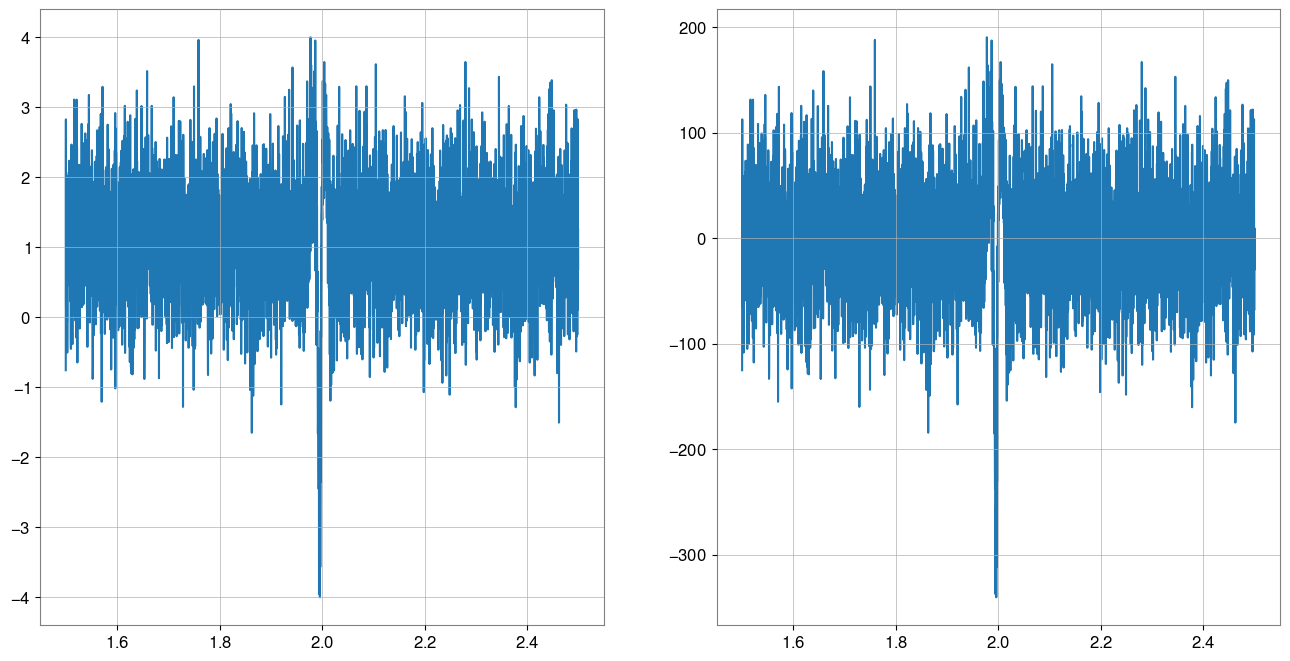

In [85]:
scaler = MinMaxScaler(feature_range=(-4,4))
# fig,ax = plt.subplots(figsize=(6,10))

fig, ax = plt.subplots(1,2,dpi=100, figsize=(16,8))
ax[0].plot(data_df_tomte['t'].iloc[4], scaler.fit_transform(data_df_tomte['y'].iloc[4].reshape(-1,1)), label="Shapiro p-value")
ax[1].plot(data_df_tomte['t'].iloc[4], data_df_tomte['y'].iloc[4], label="Shapiro p-value (rescaled)")

plt.show()

# Confusion Matrices for the chosen statistics


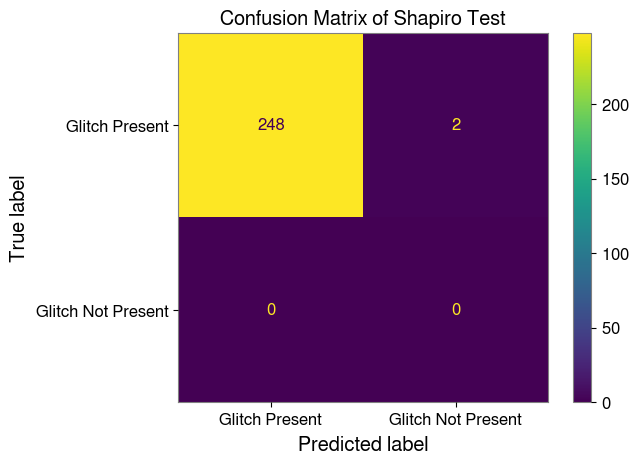

In [86]:
# cm = statistical_testing.generate_confusion_matrix(data_df_tomte)
statistical_testing.display_confusion_matrix(data_df_tomte)

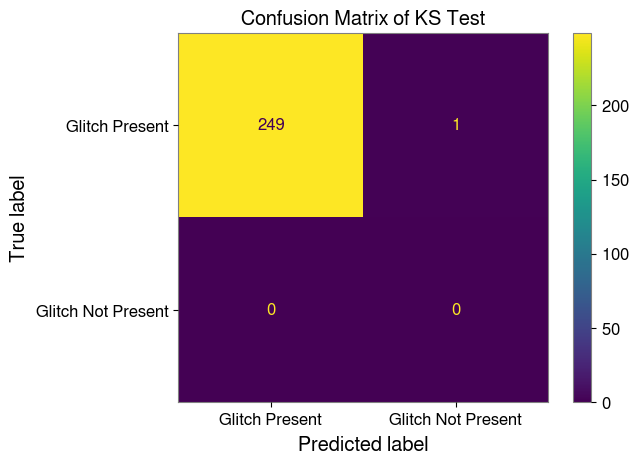

In [87]:
# cm = statistical_testing.generate_confusion_matrix(data_df_tomte,'KS')
statistical_testing.display_confusion_matrix(data_df_tomte,'KS')

In [88]:
scattered_light_selction = glitches[(glitches['label'] == 'Scattered_Light') & (glitches['ifo'] == 'L1')]

In [89]:
df_Scattered_Light_5s = statistical_testing.fetch_glitch_data_from_csv(scattered_light_selction, n_samples=250)

Failed to generate q-transform for 1252088898.875
Input signal contains non-numerical values


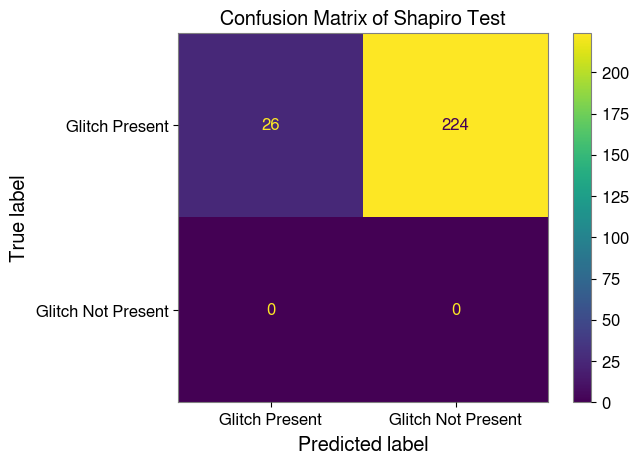

In [90]:
# cm = statistical_testing.generate_confusion_matrix(df_Scattered_Light_5s)
statistical_testing.display_confusion_matrix(df_Scattered_Light_5s)

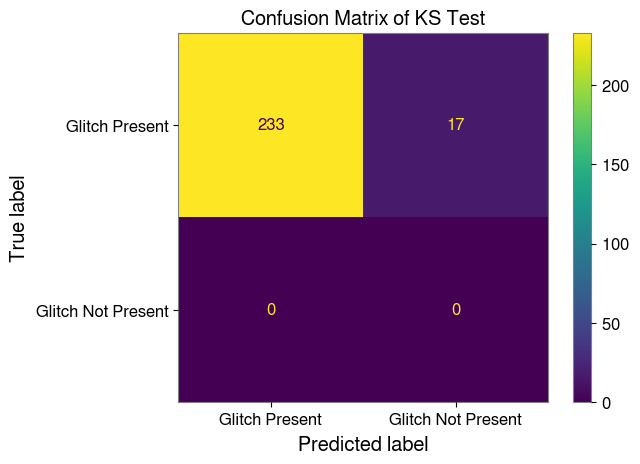

In [91]:
# cm = statistical_testing.generate_confusion_matrix(df_Scattered_Light_5s, "KS")
statistical_testing.display_confusion_matrix(df_Scattered_Light_5s, "KS")

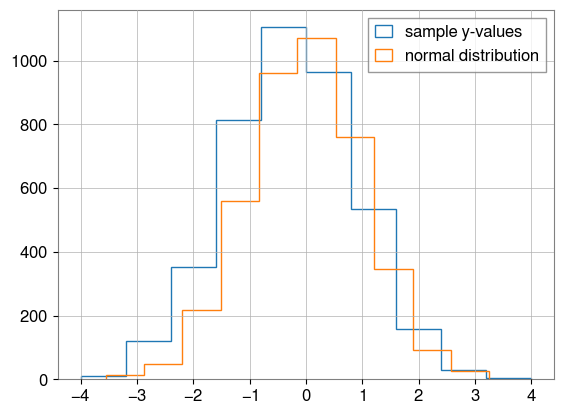

In [92]:
idx = 2

fig = plt.figure(dpi=100)
plt.hist(scaler.fit_transform(df_Scattered_Light_5s['y'].iloc[idx].reshape(-1,1)), label="sample y-values", histtype='step')
plt.hist(stats.norm.rvs(size=len(df_Scattered_Light_5s['y'].iloc[idx]), random_state=np.random.default_rng()), label="normal distribution", histtype='step')
plt.legend()
plt.show()

Judging from previous testing I have found that

- The **tomte** glitches, for the most part behave well with the Shapiro-Wilks test, giving us a p-value of less than 0.05. There are two main cases here where the test fails, and we observe that both these cases have relatively low signal-to-noise ratios.
  - The first sample is at GPS time 1251419205.832, with an SNR of 18.001. The q-scan of this glitch shows us two peaks instead of one which would be expected from a tomte glitch. There is a high possibility that this could have led to the test failing.
  - The second sample is at GPS time 1241711101.473 with an SNR of 16.089. The time series of this glitch shows a number of neighboring peaks along with the current glitch. There is a chance that this coupled with the low SNR could have contributed to the Shapiro-Wilks test failing.

- In these cases I found that the Kolmogorov-Smirnov test seems to work well at detecting a deviation of our glitches' ampltude distribution from that of a randomly sampled normal distribution.
  - I would, however, not trust this test wholly at its current state, since it compares our glitch with a synthesized normal distribution instead of actual on-ground interferometer signals, which are not necessarily gaussian.

- I performed the same tests on 50 samples of Scattered light glitches and found that the Shapiro-Wilks test failed in detecting the presence of a glitch for most cases, while the Kolmogorov-Smirnov test worked fairly well with a few false negatives.
  - An important consideration hee is that the time window was 5 seconds around the glitch, while scattered light glitches can have very large time windows. Hence making this test invalid.

I will perform the same test as before but with a larger time window on the scattered light glitches

In [93]:
# This will result in the final time window tested being 5.5 seconds arond the glitch (-4.5 seconds on each side) 
df_Scattered_Light_10s = statistical_testing.fetch_glitch_data_from_csv(scattered_light_selction,tw=10, begin=0, n_samples=250)

Failed to generate q-transform for 1252088898.875
Input signal contains non-numerical values
Failed to generate q-transform for 1253331036.938
Input signal contains non-numerical values


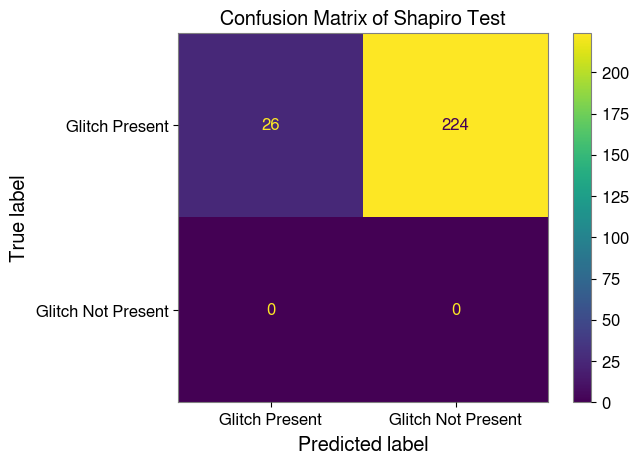

In [94]:
# cm = statistical_testing.generate_confusion_matrix(df_Scattered_Light_10s)
statistical_testing.display_confusion_matrix(df_Scattered_Light_10s)

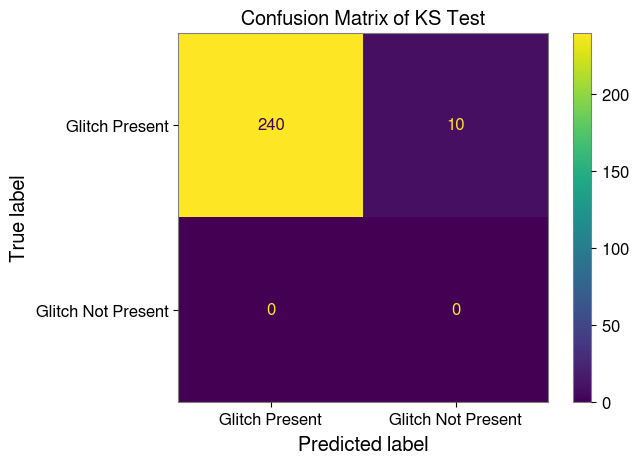

In [95]:
# cm = statistical_testing.generate_confusion_matrix(df_Scattered_Light_10s, "KS")
statistical_testing.display_confusion_matrix(df_Scattered_Light_10s, "KS")

The results seem to be similar. However, a good rule of thumb would be to look at the evvaluation metrics (Accuracy, Precision, Recall and F1 Score).

Looking at the evaluation metrics for the Shapiro-Wilks test, we get

In [96]:
cm = statistical_testing.generate_confusion_matrix(df_Scattered_Light_10s)
print("Accuracy, Precision, Recall, F1 Score:", statistical_testing.generate_evaluation_metrics(cm))



Accuracy, Precision, Recall, F1 Score: (np.float64(0.104), np.float64(1.0), np.float64(0.104), np.float64(0.18840579710144925))


Applying the same for the Kolmogorov-Smirnov test, we get

In [97]:
cm = statistical_testing.generate_confusion_matrix(df_Scattered_Light_10s, "KS")
print("Accuracy, Precision, Recall, F1 Score:", statistical_testing.generate_evaluation_metrics(cm))

Accuracy, Precision, Recall, F1 Score: (np.float64(0.96), np.float64(1.0), np.float64(0.96), np.float64(0.9795918367346939))


# Testing the Shapiro-Wilks and Kolmogorov-Smirnov tests with different glitch samples

Now that I have all the glitches at hand. I want to test how the Shapiro-Wilks and Kolmogorov-Smirnov tests work on each of the glitch samples.

First, however, I want to sample 100 of each type of glitch

In [125]:
if not os.path.isfile("./glitches/random_samples.csv"):
    sample_df = glitches[glitches['ifo'] == 'L1'].groupby('label').apply(lambda x: x.sample(n=min(len(x),50))).reset_index(drop=True)
    sample_df.to_csv("./glitches/random_samples.csv", index=False)
else:
    sample_df = pd.read_csv("./glitches/random_samples.csv", index_col=False)

In [126]:
glitches["label"].value_counts()

label
Scattered_Light        26233
Low_Frequency_Burst    23872
Fast_Scattering        21898
Tomte                  19934
No_Glitch              13119
Extremely_Loud         12516
Low_Frequency_Lines    12288
Koi_Fish               10288
Blip_Low_Frequency      8616
Whistle                 7365
Blip                    6526
1400Ripples             2388
None_of_the_Above       1713
Power_Line              1399
Scratchy                1325
Repeating_Blips         1274
Air_Compressor           640
Violin_Mode              544
Paired_Doves             232
Helix                    206
Light_Modulation         196
Wandering_Line           169
1080Lines                 14
Chirp                     10
Name: count, dtype: int64

In [127]:
sample_df.shape

(1006, 6)

In [128]:
sample_df["label"].value_counts()

label
1400Ripples            50
Air_Compressor         50
Blip                   50
Extremely_Loud         50
Blip_Low_Frequency     50
Koi_Fish               50
Fast_Scattering        50
Tomte                  50
Repeating_Blips        50
Light_Modulation       50
Low_Frequency_Burst    50
No_Glitch              50
Low_Frequency_Lines    50
Paired_Doves           50
Power_Line             50
Whistle                50
Violin_Mode            50
Scattered_Light        50
Scratchy               50
Helix                  21
Wandering_Line         20
1080Lines               9
Chirp                   6
Name: count, dtype: int64

The following code will take a lot of time to execute. I have put safeguards in place to skip files that fail to load. I would normally use a progress bar for this but the issue with that would be the size of the file increasing considerably. Instead, you can confirm the code to be working by opening a terminal, changing directory to the `glitch_timeseries_data/` folder and running the following command

```bash
find . -type f -name 'sample*' | wc -l
```
If you see the count increasing with subsequent executions of this command, it means that the code is mostly working as expected.

In [129]:
labels = ['1080Lines', '1400Ripples', 'Air_Compressor', 'Blip',
       'Blip_Low_Frequency', 'Chirp', 'Extremely_Loud',
       'Fast_Scattering', 'Helix', 'Koi_Fish',
       'Light_Modulation', 'Low_Frequency_Burst',
       'Low_Frequency_Lines', 'No_Glitch', 'Paired_Doves',
       'Power_Line', 'Repeating_Blips', 'Scattered_Light',
       'Scratchy', 'Tomte', 'Violin_Mode', 'Wandering_Line',
       'Whistle']

columns = ['label', "shapiro_TP", "shapiro_FN", "shapiro_FP", "shapiro_TN", "shapiro_accuracy", "shapiro_precision", "shapiro_recall", "shapiro_f1_score", "KS_TP", "KS_FN", "KS_FP", "KS_TN", "KS_accuracy", "KS_precision", "KS_recall", "KS_f1_score"]


def generate_glitchwise_confusion_matrices(df):
    confusion_matrix_df = pd.DataFrame(columns=columns)
    for label in labels:
        temp_df = df[df['label'] == label]
        print(f"Loading {label} data...")
        temp_df = statistical_testing.fetch_glitch_data_from_csv(temp_df, tw=10)
        temp_df.dropna(inplace=True)
        print(f"Generating confusion matrix for {label}...")
        shapiro_cm = statistical_testing.generate_confusion_matrix(temp_df)
        ks_cm = statistical_testing.generate_confusion_matrix(temp_df, "KS")

        shapiro_metrics = list(statistical_testing.generate_evaluation_metrics(shapiro_cm))
        ks_metrics = list(statistical_testing.generate_evaluation_metrics(ks_cm))

        shapiro_cm = shapiro_cm.flatten()
        ks_cm = ks_cm.flatten()

        confusion_matrix_df = pd.concat([confusion_matrix_df, pd.DataFrame([[label] + shapiro_cm.tolist() + shapiro_metrics + ks_cm.tolist() + ks_metrics], columns=columns)], ignore_index=True)

    return confusion_matrix_df
    

In [130]:
results = generate_glitchwise_confusion_matrices(sample_df)

Loading 1080Lines data...
Generating confusion matrix for 1080Lines...
Loading 1400Ripples data...
Generating confusion matrix for 1400Ripples...
Loading Air_Compressor data...
Generating confusion matrix for Air_Compressor...
Loading Blip data...
Generating confusion matrix for Blip...
Loading Blip_Low_Frequency data...
Generating confusion matrix for Blip_Low_Frequency...
Loading Chirp data...
Generating confusion matrix for Chirp...
Loading Extremely_Loud data...
Generating confusion matrix for Extremely_Loud...
Loading Fast_Scattering data...
Generating confusion matrix for Fast_Scattering...
Loading Helix data...
Generating confusion matrix for Helix...
Loading Koi_Fish data...
Generating confusion matrix for Koi_Fish...
Loading Light_Modulation data...
Generating confusion matrix for Light_Modulation...
Loading Low_Frequency_Burst data...
Failed to generate q-transform for 1249605198.875
Input signal contains non-numerical values
Generating confusion matrix for Low_Frequency_Burs

From the given results, we can see that the Shapiro-Wilks test has a lot of false negatives in comaprison to the Kolmogorov-Smirnov test. There is a chance that this could be indicative of The Shapiro-Wilks test failing for a lot of the gltiches.

## Regarding the Data Quality of the Glitches

From above, we have seen that the Shapiro-Wilks test has a large number of false negatives, while the Kolmogorov-Smirnov test works better. One of the assumptions for why this occurs is the quality of the data we are working with.

The samples at hand though large in number, are not necessarily good examples of typical glitch samples we would expect to see from an interferometer run. For this, we have generated a new dataset that selects examples of glitches that "behave well"

I will be performing the tests once more on these glitches to see how the results change.

In [131]:
dq_glitches = pd.read_csv('./glitches/DQ_glitches_O3a.csv', usecols=['GPStime', 'snr', 'duration', 'confidence', 'ifo', 'label'])
dq_glitches = dq_glitches[~dq_glitches.duplicated(subset=['GPStime'], keep='first')]

if not os.path.isfile("./glitches/random_dq_filtered_samples.csv"):
    dq_sample_df = dq_glitches[dq_glitches['ifo'] == 'L1'].groupby('label').apply(lambda x: x.sample(n=min(len(x),50))).reset_index(drop=True)
    dq_sample_df.to_csv("./glitches/random_dq_filtered_samples.csv", index=False)
else:
    dq_sample_df = pd.read_csv("./glitches/random_dq_filtered_samples.csv", index_col=False)

In [132]:
dq_glitches["label"].value_counts()

label
Fast_Scattering        21378
Tomte                  18688
Blip_Low_Frequency      7530
Scattered_Light         5337
No_Glitch               5324
Extremely_Loud          4302
Koi_Fish                4255
1400Ripples             2363
Blip                    1943
Power_Line              1189
Low_Frequency_Burst     1180
Low_Frequency_Lines      784
Whistle                  636
Air_Compressor           364
Scratchy                 203
Repeating_Blips          161
Violin_Mode              161
Paired_Doves             155
Light_Modulation          72
Helix                     21
Wandering_Line             9
Chirp                      6
1080Lines                  6
Name: count, dtype: int64

In [133]:
dq_sample_df.shape

(992, 6)

In [134]:
dq_sample_df["label"].value_counts()

label
1400Ripples            50
Air_Compressor         50
Blip                   50
Extremely_Loud         50
Blip_Low_Frequency     50
Koi_Fish               50
Fast_Scattering        50
Tomte                  50
Repeating_Blips        50
Light_Modulation       50
Low_Frequency_Burst    50
No_Glitch              50
Low_Frequency_Lines    50
Paired_Doves           50
Power_Line             50
Whistle                50
Violin_Mode            50
Scattered_Light        50
Scratchy               50
Helix                  21
Wandering_Line          9
Chirp                   6
1080Lines               6
Name: count, dtype: int64

In [135]:
dq_results = generate_glitchwise_confusion_matrices(dq_sample_df)

Loading 1080Lines data...


Generating confusion matrix for 1080Lines...
Loading 1400Ripples data...
Generating confusion matrix for 1400Ripples...
Loading Air_Compressor data...
Generating confusion matrix for Air_Compressor...
Loading Blip data...
Generating confusion matrix for Blip...
Loading Blip_Low_Frequency data...
Generating confusion matrix for Blip_Low_Frequency...
Loading Chirp data...
Generating confusion matrix for Chirp...
Loading Extremely_Loud data...
Generating confusion matrix for Extremely_Loud...
Loading Fast_Scattering data...
Generating confusion matrix for Fast_Scattering...
Loading Helix data...
Generating confusion matrix for Helix...
Loading Koi_Fish data...
Failed to generate q-transform for 1251079080.395
Input signal contains non-numerical values
Generating confusion matrix for Koi_Fish...
Loading Light_Modulation data...
Generating confusion matrix for Light_Modulation...
Loading Low_Frequency_Burst data...
Failed to generate q-transform for 1251554429.547
Input signal contains non-

In [136]:
dq_results

label shapiro_TP shapiro_FN shapiro_FP shapiro_TN  \
0             1080Lines          4          2          0          0   
1           1400Ripples         33         17          0          0   
2        Air_Compressor          4         46          0          0   
3                  Blip         50          0          0          0   
4    Blip_Low_Frequency          8         42          0          0   
5                 Chirp          2          4          0          0   
6        Extremely_Loud         50          0          0          0   
7       Fast_Scattering          2         48          0          0   
8                 Helix         19          2          0          0   
9              Koi_Fish         49          0          0          0   
10     Light_Modulation         47          3          0          0   
11  Low_Frequency_Burst          2         46          0          0   
12  Low_Frequency_Lines          2         48          0          0   
13            No_Glitch         18         32          0          0   
14         Paired_Doves         22         28          0          0   
15           Power_Line          3         46          0          0   
16      Repeating_Blips         49          1          0          0   
17      Scattered_Light          5         44          0          0   
18             Scratchy          2         21          0          0   
19                Tomte         26         24          0          0   
20          Violin_Mode         41          9          0          0   
21       Wandering_Line          9          0          0          0   
22              Whistle         45          5          0          0   

    shapiro_accuracy  shapiro_precision  shapiro_recall  shapiro_f1_score  \
0            0.66667            1.00000         0.66667           0.80000   
1            0.66000            1.00000         0.66000           0.79518   
2            0.08000            1.00000         0.08000           0.14815   
3            1.00000            1.00000         1.00000           1.00000   
4            0.16000            1.00000         0.16000           0.27586   
5            0.33333            1.00000         0.33333           0.50000   
6            1.00000            1.00000         1.00000           1.00000   
7            0.04000            1.00000         0.04000           0.07692   
8            0.90476            1.00000         0.90476           0.95000   
9            1.00000            1.00000         1.00000           1.00000   
10           0.94000            1.00000         0.94000           0.96907   
11           0.04167            1.00000         0.04167           0.08000   
12           0.04000            1.00000         0.04000           0.07692   
13           0.36000            1.00000         0.36000           0.52941   
14           0.44000            1.00000         0.44000           0.61111   
15           0.06122            1.00000         0.06122           0.11538   
16           0.98000            1.00000         0.98000           0.98990   
17           0.10204            1.00000         0.10204           0.18519   
18           0.08696            1.00000         0.08696           0.16000   
19           0.52000            1.00000         0.52000           0.68421   
20           0.82000            1.00000         0.82000           0.90110   
21           1.00000            1.00000         1.00000           1.00000   
22           0.90000            1.00000         0.90000           0.94737   

   KS_TP KS_FN KS_FP KS_TN  KS_accuracy  KS_precision  KS_recall  KS_f1_score  
0      6     0     0     0      1.00000       1.00000    1.00000      1.00000  
1     49     1     0     0      0.98000       1.00000    0.98000      0.98990  
2     48     2     0     0      0.96000       1.00000    0.96000      0.97959  
3     50     0     0     0      1.00000       1.00000    1.00000      1.00000  
4     49     1     0     0      0.98000       1.00000    0.98000

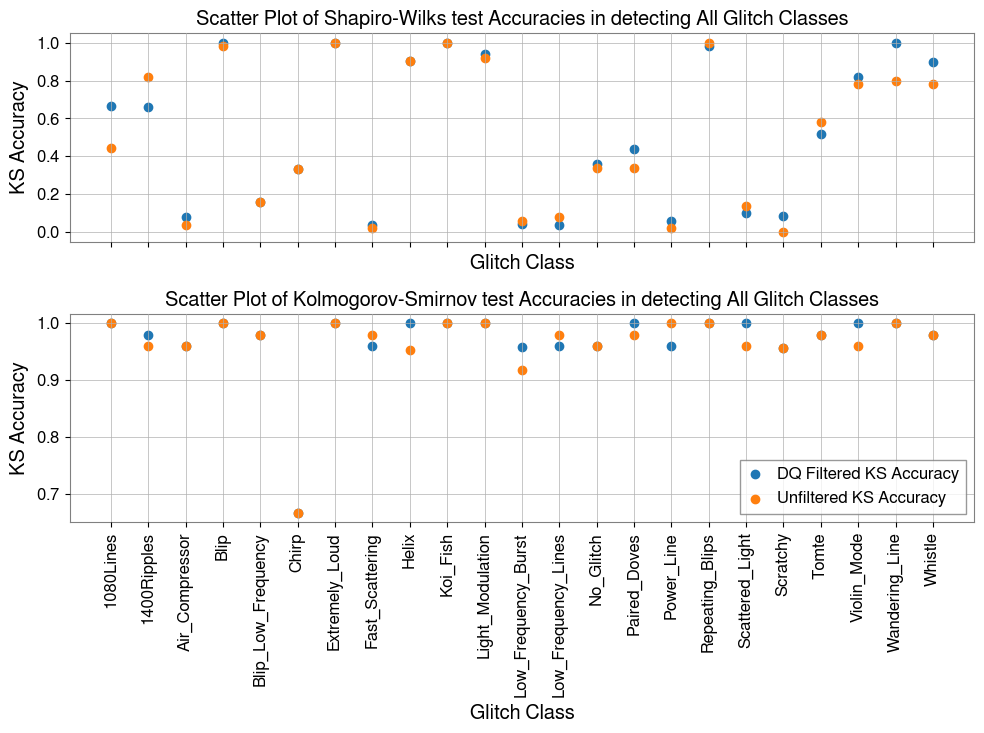

In [146]:
fig,ax = plt.subplots(2,1,figsize=(10, 6), sharex=True)
# for glitch_class in dq_sample_df['glitch_class'].unique():
#     class_data = dq_sample_df[dq_sample_df['glitch_class'] == glitch_class]
#     plt.scatter(class_data['glitch_class'], class_data['KS_accuracy'], label=glitch_class)

# Add labels and title
ax[0].scatter(dq_results["label"], dq_results["shapiro_accuracy"])
ax[0].scatter(results["label"], results["shapiro_accuracy"])
ax[0].set_xlabel('Glitch Class')
ax[0].set_ylabel('KS Accuracy')
ax[0].set_title('Scatter Plot of Shapiro-Wilks test Accuracies in detecting All Glitch Classes')

ax[1].scatter(dq_results["label"], dq_results["KS_accuracy"], label="DQ Filtered KS Accuracy")
ax[1].scatter(results["label"], results["KS_accuracy"], label="Unfiltered KS Accuracy")
ax[1].set_xlabel('Glitch Class')
ax[1].set_ylabel('KS Accuracy')
ax[1].set_title('Scatter Plot of Kolmogorov-Smirnov test Accuracies in detecting All Glitch Classes')
ax[1].legend()

plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

# Studying our tests with clean data segments

Now that we have studied the given statistical tests on glitch data, I now have at hand a dataset of "clean segments" which contain examples of time intervals where no glitches were detected during the run.

In [138]:
clean_gpstimes = pd.read_csv("./clean_segments/pre_clean_segments_O3a_L1.csv", usecols=['start_time', 'end_time', 'p_values'])

In [139]:
clean_gpstimes.head()

start_time         end_time  p_values
0 1238184014.93750 1238184024.00000   0.00000
1 1238176530.30420 1238176537.55859   1.00000
2 1238198056.74707 1238198066.20508   1.00000
3 1238198327.12940 1238198335.15204   0.00001
4 1238197723.62500 1238197731.61633   1.00000

In [140]:
statistical_testing.fetch_clean_segment_samples(clean_gpstimes.iloc[0:100])

Input Length:  100
lengths do not match (14857 vs 14858)


lengths do not match (15808 vs 15809)
lengths do not match (16594 vs 16593)
lengths do not match (17889 vs 17890)
lengths do not match (15221 vs 15222)
lengths do not match (15024 vs 15023)
lengths do not match (14425 vs 14426)
lengths do not match (23318 vs 23317)
lengths do not match (15224 vs 15225)
lengths do not match (16419 vs 16420)
lengths do not match (16211 vs 16212)
lengths do not match (15199 vs 15200)
lengths do not match (17339 vs 17340)
lengths do not match (15207 vs 15208)
lengths do not match (16501 vs 16502)
lengths do not match (15500 vs 15499)
lengths do not match (16493 vs 16494)
lengths do not match (14502 vs 14503)
lengths do not match (17763 vs 17764)
lengths do not match (22077 vs 22078)
lengths do not match (14529 vs 14530)
lengths do not match (15972 vs 15971)
lengths do not match (16443 vs 16444)
lengths do not match (17754 vs 17753)
lengths do not match (15231 vs 15232)
lengths do not match (19385 vs 19386)
lengths do not match (15702 vs 15701)
lengths do n